In [1]:
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d

# Process Data

In [2]:
def preprocess(data):
    load = list(data["Load"])
    for i in load:
        if i >= 0.5:
            ind = load.index(i)
            #data.loc[ind:, "Displ."] = np.array(data.loc[ind:, "Displ."]) - data.loc[ind, "Displ."]
            break
            
    new_data = pd.DataFrame.drop(data, axis=0, index=list(range(ind)))
    return new_data

In [3]:
def stress_strain(data, dimension, rel_density, height):
    area = dimension[1] * dimension[0]
    stress, strain = np.array(data["Load"])/area, np.array(data["Displ."])/height
    return stress, strain

In [4]:
def find_strengh(stress, strain, limit = 0.6):
    k = list(abs(strain - limit)).index(min(abs(strain - limit)))
    list_stress = list(stress)
    strengh = max(list_stress[0 : k])
    ind = list_stress.index(strengh)
    disp = strain[ind]
    return strengh, disp

In [5]:
def find_elastic_modulus(stress, strain, limit1, limit2):
    ind1 = list(abs(strain - limit1)).index(min(abs(strain - limit1)))
    ind2 = list(abs(strain - limit2)).index(min(abs(strain - limit2)))
    
    y = stress[ind1:ind2]
    x = strain[ind1:ind2]
    
    f = np.polyfit(x, y, 1)
    expression = np.poly1d(f)
    elastic_mod = f[0]
    return elastic_mod, f, expression

In [6]:
def find_energy_absorption(stress, strain):
    return np.trapz(stress, strain)

In [7]:
def energy_absorption_efficiency(stress, strain, frequency = 50):
    energy_absorption = []
    new_strain = []

    for i in range(1, strain.shape[0]):
        if i % frequency != 1:
            continue
        
        en_abs = np.trapz(stress[0:i], strain[0:i])
        efficiency = en_abs/(max(stress[0:i])) * 100
        energy_absorption.append(efficiency)
        new_strain.append(strain[i])
        
    max_energy_absorption = max(energy_absorption)
    ind = energy_absorption.index(max_energy_absorption)
    densification_strain = new_strain[ind]
    
    
    return densification_strain, max_energy_absorption, energy_absorption, new_strain

In [8]:
def energy_aborption(stress, strain, dens, frequency = 50):
    energy_absorption = []
    new_strain = []
    ind = list(strain - dens).index(min(abs(strain - dens)))
    
    for i in range(1, ind):
        if i % frequency != 1:
            continue
        
        en_abs = np.trapz(stress[0:i], strain[0:i])
        energy_absorption.append(en_abs)
        new_strain.append(strain[i])
    
    ig, ax = plt.subplots()
    ax.plot(new_strain, energy_absorption)
    max_energy_abs = max(energy_absorption)
    
    return max_energy_abs, energy_absorption, new_strain

In [9]:
def find_ultimate_strengh(stress, strain, limit):
    strain_dec = abs(strain - limit)
    ind = np.argmin(strain_dec)
    ultimate_strengh = max(stress[: ind])
    ind_2 = np.argmax(stress[: ind])
    ultimate_strain = strain[ind_2]
    return ultimate_strengh, ultimate_strain

In [10]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\First Batch\POM"
data = pd.read_excel(path + "\\" + "POM.xlsx") 

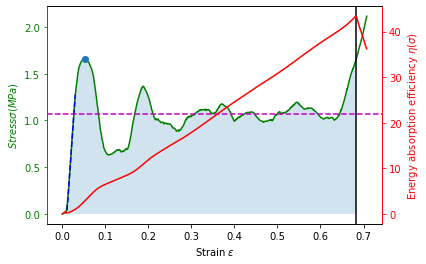

In [71]:
data = preprocess(data)

fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
limits = (0.011, 0.03)
stress, strain = stress_strain(data, dimension = (51.5, 51.5), rel_density = 0.12, height = 50)
strengh, disp = find_strengh(stress, strain, limit = 0.6)
modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[0], limit2 = limits[1])
stress1 = modulus * limits[0] + f[1]
stress2 = modulus * limits[1] + f[1]
ax1.plot(strain, stress, "-g", label = "$sigma$ vs $epsilon$")
ax1.plot(displ, strengh, marker = "o", label = "Yeild Stress")
ax1.plot(limits, (stress1, stress2), "--b", label = "Elastic Modulus")

densification_strain, max_energy_absorption, energy_absorption, new_strain = energy_absorption_efficiency(stress, strain, frequency = 50)
#
plt.axvline(x = densification_strain, color = 'k', label = "Densification Strain")
ind = np.argmin(abs(np.array(strain) - densification_strain))
ax1.fill_between(strain[:ind], stress[:ind], step = "pre", alpha = 0.2)
ax2.plot(new_strain, energy_absorption, "-r", label = "$eta(epsilon)$ versus $epsilon$")

y_index = np.where(strain == disp)[0][0]
d_index = np.where(strain == densification_strain)[0][0]
plat = np.trapz(stress[y_index: d_index], strain[y_index: d_index])/(densification_strain - disp)
ax1.axhline(y = plat, color = 'm', linestyle = '--', label = "Plateau Stress")
ax1.tick_params(axis='y', colors='green')
ax1.set_ylabel("$Stress \sigma (MPa)$")
ax1.yaxis.label.set_color('green')
ax1.spines['left'].set_color('green')
ax2.spines['left'].set_color('green')

ax1.spines['right'].set_color('red')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.set_ylabel("Energy absorption efficiency $\eta(\sigma)$")
ax2.yaxis.label.set_color('red')
ax1.set_xlabel("Strain $\epsilon$")

fig1.savefig(r"C:\Users\Daniyar Syrlybayev\Desktop\Images Paper\Fig_3.pdf")



In [10]:
def prepare_results(name, paths, names, masses, dimensions, rel_dens, limits, height = 50):
    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()
    fig4, ax4 = plt.subplots()
    fig5, ax5 = plt.subplots()

    for j in [ax1, ax2, ax3, ax4, ax5]:
        j.set_xlabel("Strain")

    ax1.set_ylabel("Stress [MPa]")
    ax2.set_ylabel("Specific Stress [MPa/kg]")
    ax3.set_ylabel("Energy Absorption [MJ/m^3]")
    ax4.set_ylabel("Specific Energy Absorption [MJ/kg]")
    ax5.set_ylabel("Energy Absorption Efficiency")

    results = [] #(Strenght, spec_strengh, modulus, spec_modulus, max_en_abs, spec_max_en_abs, dens)
    n = len(paths)
    
    for i in range(n):
        data = pd.read_excel(paths[i])
        data = preprocess(data)

        stress, strain = stress_strain(data, dimensions[i], rel_dens[i], height)
        spec_stress = stress/masses[i]

        strengh, disp = find_strengh(stress, strain, limit = 0.3)
        spec_strengh = strengh/masses[i]

        elastic_modulus, f, exp = find_elastic_modulus(stress, strain, limits[0], limits[1])
        spec_modulus = elastic_modulus/masses[i]


        dens, max_energy_absortion_eff, energy_absorption_eff, new_strain_1 = energy_absorption_efficiency(stress, strain, frequency = 30)

        max_energy_abs, energy_abs, new_strain_2 = energy_aborption(stress, strain, dens, frequency = 30)
        max_spec_energy_abs, spec_energy_abs= max_energy_abs/rel_dens[i], np.array(energy_abs)/rel_dens[i]
        
        ultimate_strengh, ultimate_strain = find_ultimate_strengh(stress, strain, dens)
        spec_ultimate_strengh = ultimate_strengh/masses[i]
        
        
        y_index = np.where(strain == disp)[0][0]
        d_index = np.where(strain == dens)[0][0]
        print(y_index, d_index)
        plat = np.trapz(stress[y_index: d_index], strain[y_index: d_index])/(dens - disp)
        spec_plat = plat/masses[i]

        result = (strengh, spec_strengh, elastic_modulus, spec_modulus, max_energy_abs, 
                  max_spec_energy_abs, dens, max_energy_absortion_eff, plat, spec_plat, disp, 
                  ultimate_strengh, spec_ultimate_strengh, ultimate_strain)
        
        results.append(result)

        ax1.plot(strain, stress, label = names[i])
        ax1.plot(disp, strengh, marker = "*")
        ax1.plot(ultimate_strain, ultimate_strengh, marker = "x")
        
        ax2.plot(strain, spec_stress, label = names[i])
        ax2.plot(disp, spec_strengh, marker = "*")
        ax2.plot(ultimate_strain, spec_ultimate_strengh, marker = "x")
        
        ax3.plot(new_strain_2, energy_abs, label = names[i])
        ax3.plot(dens, max_energy_abs, marker = "*")
        
        ax4.plot(new_strain_2, spec_energy_abs, label = names[i])
        ax4.plot(dens, max_spec_energy_abs, marker = "*")
        
        ax5.plot(new_strain_1, energy_absorption_eff, label = names[i])
        ax5.plot(dens, max_energy_absortion_eff, marker = "*")

    for i in [ax1, ax2, ax3, ax4, ax5]:
        i.legend()
    
    os.mkdir(name)
    fig1.savefig(name + "\\" + "Stress_Strain.pdf")
    fig2.savefig(name + "\\" + "Spec_Stress_Strain.pdf")
    fig3.savefig(name + "\\" + "Energy_abs.pdf")
    fig4.savefig(name + "\\" + "Spec_Spec_energy_abs.pdf")
    fig5.savefig(name + "\\" + "Energy_abs_eff.pdf")
    
    plt.close('all')
    return results

In [11]:
def process_results(pathes, labels, masses, dimensions, rel_dens, limits, height = 50):
    results = {"Yield_Strengh" : [], 
           "Spec_Yield_strengh" : [], 
          "Modulus" : [], 
          "Spec_Modulus": [], 
          "Max_En_Abs" : [],
          "Spec_Max_en_abs" : [],
          "Densification_Strain" : [], 
          "Energy_Abs_Eff" : [],  
          "Plat_stress" : [], 
          "Spec_plat_stress" : [],
          "Yield_strain" : [],
          "Ultimate_Strengh": [],
          "Spec_Ultimate_Strengh": [], 
          "Ultimate_Strain": []}
    
    m = len(pathes)
    
    for i in range(m):
        result = prepare_results(names[i], pathes[i], labels, list(masses[i, :]), dimensions[i], list(rel_dens[i]), limits[i])
        results["Yield_Strengh"].extend([result[0][0], result[1][0], result[2][0]])
        results["Spec_Yield_strengh"].extend([result[0][1], result[1][1], result[2][1]])
        results["Modulus"].extend([result[0][2], result[1][2], result[2][2]])
        results["Spec_Modulus"].extend([result[0][3], result[1][3], result[2][3]])
        results["Max_En_Abs"].extend([result[0][4], result[1][4], result[2][4]])
        results["Spec_Max_en_abs"].extend([result[0][5], result[1][5], result[2][5]])
        results["Densification_Strain"].extend([result[0][6], result[1][6], result[2][6]])
        results["Energy_Abs_Eff"].extend([result[0][7], result[1][7], result[2][7]])
        results["Plat_stress"].extend([result[0][8], result[1][8], result[2][8]])
        results["Spec_plat_stress"].extend([result[0][9], result[1][9], result[2][9]])
        results["Yield_strain"].extend([result[0][10], result[1][10], result[2][10]])
        results["Ultimate_Strengh"].extend([result[0][11], result[1][11], result[2][11]])
        results["Spec_Ultimate_Strengh"].extend([result[0][12], result[1][12], result[2][12]])
        results["Ultimate_Strain"].extend([result[0][13], result[1][13], result[2][13]])
    
        print(names[i] + " have been compiled")
        print(result)
    
    final_results = pd.DataFrame(results)
    
    return final_results

## First Batch

In [68]:
os.chdir(r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\First Batch")
names = ["PO_results", "Rhombic_results", "HVP_results", "HCh2D_results", "HCh3D_results"]
path_1 = ["POL\\POL.xlsx", "POM\\POM.xlsx", "POH\\POH.xlsx"]
path_2 = ["RL\\RL.xlsx", "RM\\RM.xlsx", "RH\\RH.xlsx"]
path_3 = ["HVPL\\HVPL.xlsx", "HVPM\\HVPM.xlsx", "HVPH\\HVPH.xlsx"]
path_4 = ["HCh2DL\\HCh2DL.xlsx", "HCh2DM\\HCh2DM.xlsx", "HCh2DH\\HCh2DH.xlsx"]
path_5 = ["HCh3DL\\HCh3DL.xlsx", "HCh3DM\\HCh3DM.xlsx", "HCh3DH\\HCh3DH.xlsx"]
pathes = [path_1, path_2, path_3, path_4, path_5]

labels = ["d = 1.5 mm", "d = 1.75 mm", "d = 2 mm"]
masses = np.array([[19.41, 25.70, 32.24], [29.78, 38.81, 48.45], [26.40, 34.56, 43.35], [25.78, 33.80, 42.46], [26.02, 34.12, 42.89]]) * 10**-3
dimensions = [[(51.5, 51.5), (51.7, 51.7), (52, 52)], [(50, 50), (50, 50), (50, 50)], [(51.5, 50), (51.7, 50), (52, 50)], [(51.5, 51.5), (51.7, 51.7), (52, 52)], [(51.5, 51.5), (51.7, 51.7), (52, 52)]]
rel_dens = np.array([[0.12, 0.16, 0.20], [0.20, 0.25, 0.32], [0.17, 0.22, 0.27], [0.16, 0.21, 0.26], [0.16, 0.21, 0.26]])
limits = [(0.011, 0.03), (0.011, 0.03), (0.02, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03)]

final_results = process_results(pathes, labels, masses, dimensions, rel_dens, limits)
final_results.to_excel(r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\First_Batch.xlsx")

1281 19951
1508 19921
1851 18661
PO_results have been compiled
[(0.9300028277877274, 47.91359236412815, 40.23196091030052, 2072.7439933179044, 0.30747751041568483, 2.5623125867973737, 0.68326, 33.162903348739164, 0.4525963298017529, 23.317688294783768, 0.04394, 0.9300028277877274, 47.91359236412815, 0.04394), (1.6413320413485029, 63.86505997464992, 64.61579816411987, 2514.233391599995, 0.7114849997568173, 4.446781248480108, 0.68238, 43.45098493309931, 1.0577615950617476, 41.15803871835594, 0.051840000000000004, 1.6413320413485029, 63.86505997464992, 0.051840000000000004), (2.599852071005917, 80.64057292201974, 93.40427951493139, 2897.155071803082, 1.2446606338757393, 6.223303169378696, 0.63914, 47.97591759601706, 1.9989062745104893, 62.000814966206235, 0.06352000000000001, 2.599852071005917, 80.64057292201974, 0.06352000000000001)]
2889 15901
2791 15781
2369 14611
Rhombic_results have been compiled
[(1.0769600000000001, 36.16386836803224, 23.439416040217495, 787.085830766202, 0.5295333

## Second Batch

In [70]:
os.chdir(r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Second Batch")
names = ["PO_results", "Rhombic_results", "HVP_results", "HCh2D_results", "HCh3D_results"]
path_1 = ["POL\\POL.xlsx", "POM\\POM.xlsx", "POH\\POH.xlsx"]
path_2 = ["RL\\RL.xlsx", "RM\\RM.xlsx", "RH\\RH.xlsx"]
path_3 = ["HVPL\\HVPL.xlsx", "HVPM\\HVPM.xlsx", "HVPH\\HVPH.xlsx"]
path_4 = ["HCh2DL\\HCh2DL.xlsx", "HCh2DM\\HCh2DM.xlsx", "HCh2DH\\HCh2DH.xlsx"]
path_5 = ["HCh3DL\\HCh3DL.xlsx", "HCh3DM\\HCh3DM.xlsx", "HCh3DH\\HCh3DH.xlsx"]
pathes = [path_1, path_2, path_3, path_4, path_5]

labels = ["d = 1.5 mm", "d = 1.75 mm", "d = 2 mm"]
masses = np.array([[19.41, 25.70, 32.24], [29.78, 38.81, 48.45], [26.40, 34.56, 43.35], [25.78, 33.80, 42.46], [26.02, 34.12, 42.89]]) * 10**-3
dimensions = [[(51.5, 51.5), (51.7, 51.7), (52, 52)], [(50, 50), (50, 50), (50, 50)], [(51.5, 50), (51.7, 50), (52, 50)], [(51.5, 51.5), (51.7, 51.7), (52, 52)], [(51.5, 51.5), (51.7, 51.7), (52, 52)]]
rel_dens = np.array([[0.12, 0.16, 0.20], [0.20, 0.25, 0.32], [0.17, 0.22, 0.27], [0.16, 0.21, 0.26], [0.16, 0.21, 0.26]])
limits = [(0.013, 0.03), (0.013, 0.03), (0.02, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03)]

final_results = process_results(pathes, labels, masses, dimensions, rel_dens, limits)
final_results.to_excel(r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Second_Batch.xlsx")

1328 21961
1623 20581
1830 18361
PO_results have been compiled
[(0.8637194834574419, 44.49868539193415, 36.8521005379161, 1898.6141441481761, 0.3121485323781694, 2.6012377698180784, 0.75232, 36.24315736860485, 0.4128902957531272, 21.27203996667322, 0.045759999999999995, 0.8637194834574419, 44.49868539193415, 0.045759999999999995), (1.5780297730172208, 61.40193669327707, 62.316325252550335, 2424.75973745332, 0.6880371545405908, 4.300232215878692, 0.70504, 43.70249439294436, 0.988286020261544, 38.45470895959315, 0.05586, 1.5780297730172208, 61.40193669327707, 0.05586), (2.731878698224852, 84.73569163228449, 100.81289242438757, 3126.950757580259, 1.3059403838757397, 6.529701919378699, 0.62868, 47.87261408801288, 2.1337092045410113, 66.1820472872522, 0.06262, 2.733764792899408, 84.7941933281454, 0.62864)]
2812 15991
2755 15631
2531 15091
Rhombic_results have been compiled
[(1.15056, 38.635325721961046, 25.229743465095012, 847.2042802248156, 0.56503183, 2.8251591499999997, 0.54782, 42.20258

### Stress and Strain Plots Comparison

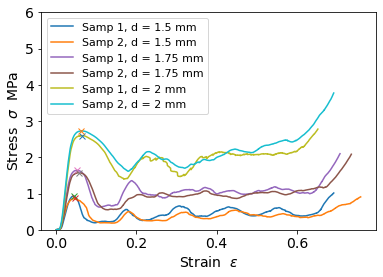

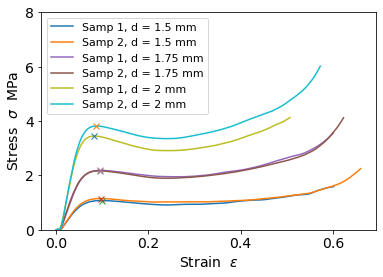

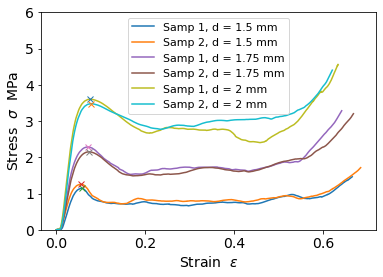

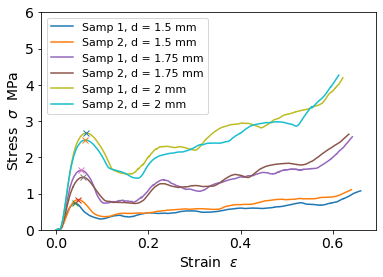

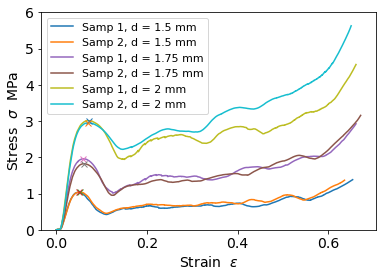

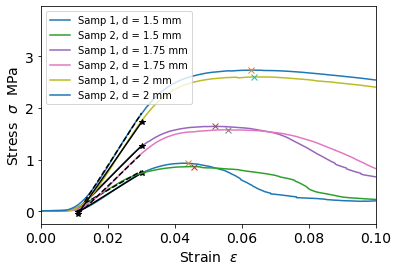

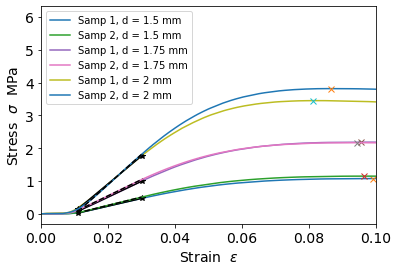

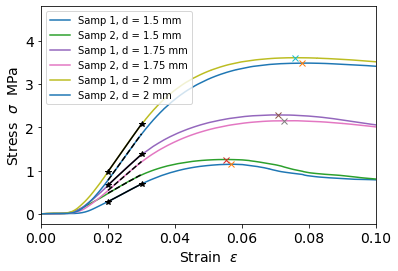

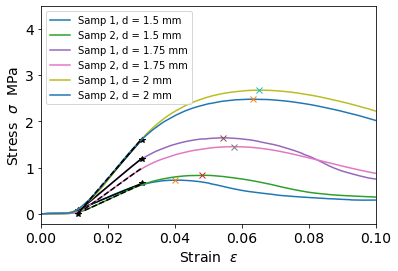

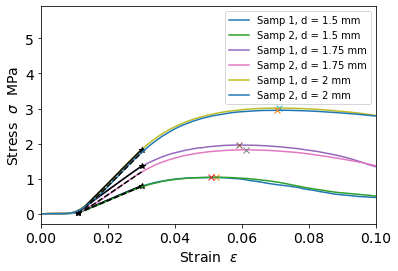

In [23]:
main_path_1 = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\First Batch"
main_path_2 = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Second Batch"
path = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression"

names = ["PO_results", "Rhombic_results", "HVP_results", "HCh2D_results", "HCh3D_results"]
path_1 = ["POL\\POL.xlsx", "POM\\POM.xlsx", "POH\\POH.xlsx"]
path_2 = ["RL\\RL.xlsx", "RM\\RM.xlsx", "RH\\RH.xlsx"]
path_3 = ["HVPL\\HVPL.xlsx", "HVPM\\HVPM.xlsx", "HVPH\\HVPH.xlsx"]
path_4 = ["HCh2DL\\HCh2DL.xlsx", "HCh2DM\\HCh2DM.xlsx", "HCh2DH\\HCh2DH.xlsx"]
path_5 = ["HCh3DL\\HCh3DL.xlsx", "HCh3DM\\HCh3DM.xlsx", "HCh3DH\\HCh3DH.xlsx"]
pathes = [path_1, path_2, path_3, path_4, path_5]

labels = ["d = 1.5 mm", "d = 1.75 mm", "d = 2 mm"]
masses = np.array([[19.41, 25.70, 32.24], [29.78, 38.81, 48.45], [26.40, 34.56, 43.35], [25.78, 33.80, 42.46], [26.02, 34.12, 42.89]]) * 10**-3
dimensions = [[(51.5, 51.5), (51.7, 51.7), (52, 52)], [(50, 50), (50, 50), (50, 50)], [(51.5, 50), (51.7, 50), (52, 50)], [(51.5, 51.5), (51.7, 51.7), (52, 52)], [(51.5, 51.5), (51.7, 51.7), (52, 52)]]
rel_dens = np.array([[0.12, 0.16, 0.20], [0.20, 0.25, 0.32], [0.17, 0.22, 0.27], [0.16, 0.21, 0.26], [0.16, 0.21, 0.26]])
limits1 = [(0.011, 0.03), (0.011, 0.03), (0.02, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03)]
limits2 = [(0.013, 0.03), (0.013, 0.03), (0.02, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03)]

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()

fig6, ax6 = plt.subplots()
fig7, ax7 = plt.subplots()
fig8, ax8 = plt.subplots()
fig9, ax9 = plt.subplots()
fig10, ax10 = plt.subplots()
plots = [ax1, ax2, ax3, ax4, ax5]
plots_el = [ax6, ax7, ax8, ax9, ax10]

figs = [fig1, fig2, fig3, fig4, fig5]
figs_el = [fig6, fig7, fig8, fig9, fig10]
lims = [6, 8, 6, 6, 6]
savepath = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\SS_Comparison"


for i in range(5):
    for j in range(3):
        first_batch = pd.read_excel(main_path_1 + "\\" + pathes[i][j])
        second_batch = pd.read_excel(main_path_2 + "\\" + pathes[i][j])
        
        stress_1, strain_1 = stress_strain(first_batch, dimensions[i][j], rel_dens[i][j], height = 50)
        stress_2, strain_2 = stress_strain(second_batch, dimensions[i][j], rel_dens[i][j], height = 50)
        
        strengh_1, disp_1 = find_strengh(stress_1, strain_1, limit = 0.3)
        strengh_2, disp_2 = find_strengh(stress_2, strain_2, limit = 0.3)
        
        modulus1, f1, _ = find_elastic_modulus(stress_1, strain_1, limit1 = limits1[i][0], limit2 = limits1[i][1])
        stress1 = modulus1 * limits1[i][0] + f1[1]
        stress2 = modulus1 * limits1[i][1] + f1[1]
        
        modulus2, f2, _ = find_elastic_modulus(stress_2, strain_2, limit1 = limits2[i][0], limit2 = limits2[i][1])
        stress3 = modulus2 * limits2[i][0] + f2[1]
        stress4 = modulus2 * limits2[i][1] + f2[1]
        
        
        
        plots_el[i].plot(strain_1, stress_1, label = "Samp 1, " + labels[j])
        plots_el[i].plot(disp_1, strengh_1, marker = "x")
        plots_el[i].plot([limits1[i][0], limits1[i][1]], [stress1, stress2], "-*k")
        
        plots_el[i].plot(strain_2, stress_2, label = "Samp 2, " + labels[j])
        plots_el[i].plot(disp_2, strengh_2, marker = "x")
        plots_el[i].plot([limits2[i][0], limits2[i][1]], [stress3, stress4], "--k")
        
        plots_el[i].set_xlim(0, 0.1)
        plots[i].set_ylim(0, lims[i])
        plots_el[i].legend(prop={'size': 10})
        
        plots[i].plot(strain_1, stress_1, label = "Samp 1, " + labels[j])
        plots[i].plot(strain_2, stress_2, label = "Samp 2, " + labels[j])
        plots[i].plot(disp_1, strengh_1, marker = "x")
        plots[i].plot(disp_2, strengh_2, marker = "x")
        plots[i].legend(prop={'size': 11})
        plots[i].set_xlabel('Strain  $\epsilon$', fontsize = 14)
        plots[i].set_ylabel('Stress  $\sigma$  MPa', fontsize = 14)
        plt.rcParams['font.size'] = '14'
        plots_el[i].set_xlabel('Strain  $\epsilon$')
        plots_el[i].set_ylabel('Stress  $\sigma$  MPa')
        figs[i].savefig(savepath + "\\" + names[i] + ".pdf", bbox_inches="tight")
        figs_el[i].savefig(savepath + "\\" + names[i] + "elastic.pdf", bbox_inches="tight")
        
        

## Energy Absoprtion vs. Strain

In [32]:
main_path_1 = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\First Batch"
main_path_2 = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Second Batch"
path = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression"

names = ["PO_results", "Rhombic_results", "HVP_results", "HCh2D_results", "HCh3D_results"]
path_1 = ["POL\\POL.xlsx", "POM\\POM.xlsx", "POH\\POH.xlsx"]
path_2 = ["RL\\RL.xlsx", "RM\\RM.xlsx", "RH\\RH.xlsx"]
path_3 = ["HVPL\\HVPL.xlsx", "HVPM\\HVPM.xlsx", "HVPH\\HVPH.xlsx"]
path_4 = ["HCh2DL\\HCh2DL.xlsx", "HCh2DM\\HCh2DM.xlsx", "HCh2DH\\HCh2DH.xlsx"]
path_5 = ["HCh3DL\\HCh3DL.xlsx", "HCh3DM\\HCh3DM.xlsx", "HCh3DH\\HCh3DH.xlsx"]
pathes = [path_1, path_2, path_3, path_4, path_5]

labels = ["d = 1.5 mm", "d = 1.75 mm", "d = 2 mm"]
masses = np.array([[19.41, 25.70, 32.24], [29.78, 38.81, 48.45], [26.40, 34.56, 43.35], [25.78, 33.80, 42.46], [26.02, 34.12, 42.89]]) * 10**-3
dimensions = [[(51.5, 51.5), (51.7, 51.7), (52, 52)], [(50, 50), (50, 50), (50, 50)], [(51.5, 50), (51.7, 50), (52, 50)], [(51.5, 51.5), (51.7, 51.7), (52, 52)], [(51.5, 51.5), (51.7, 51.7), (52, 52)]]
rel_dens = np.array([[0.12, 0.16, 0.20], [0.20, 0.25, 0.32], [0.17, 0.22, 0.27], [0.16, 0.21, 0.26], [0.16, 0.21, 0.26]])
limits1 = [(0.011, 0.03), (0.011, 0.03), (0.02, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03), (0.011, 0.03)]
limits2 = [(0.013, 0.03), (0.013, 0.03), (0.02, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03), (0.013, 0.03)]

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()

fig6, ax6 = plt.subplots()
fig7, ax7 = plt.subplots()
fig8, ax8 = plt.subplots()
fig9, ax9 = plt.subplots()
fig10, ax10 = plt.subplots()
plots = [ax1, ax2, ax3, ax4, ax5]
plots_ef = [ax6, ax7, ax8, ax9, ax10]

figs = [fig1, fig2, fig3, fig4, fig5]
figs_ef = [fig6, fig7, fig8, fig9, fig10]
savepath = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\En_abs_Comparison"

for i in range(5):
    for j in range(3):
        data1 = pd.read_excel(main_path_1 + "\\" + pathes[i][j])
        data2 = pd.read_excel(main_path_2 + '\\' + pathes[i][j])
        stress1, strain1 = stress_strain(preprocess(data1), dimension = dimensions[i][j], rel_density = rel_dens[i, j], height = 50)
        stress2, strain2 = stress_strain(preprocess(data2), dimension = dimensions[i][j], rel_density = rel_dens[i, j], height = 50)
        
        dens1, max_en_absorption1, en_absorption1, new_str1 = energy_absorption_efficiency(stress1, strain1, frequency = 50)
        max_energy_abs1, energy_abs1, new_strain1 = energy_aborption(stress1, strain1, dens1, frequency = 50)
        
        dens2, max_en_absorption2, en_absorption2, new_str2 = energy_absorption_efficiency(stress2, strain2)
        max_energy_abs2, energy_abs2, new_strain2 = energy_aborption(stress2, strain2, dens2)
        
        plots[i].plot(new_strain1, energy_abs1, label = 'Sample 1 ' + labels[j])
        plots[i].plot(new_strain2, energy_abs2, label = 'Sample 2 ' + labels[j])
        #plots[i].plot(dens1, max_energy_abs1, marker = 'o')
        #plots[i].plot(dens2, max_energy_abs2, marker = 'o')
        
        plots_ef[i].plot(new_str1, en_absorption1, label = 'Sample 1 ' + labels[j])
        plots_ef[i].plot(new_str2, en_absorption2, label = 'Sample 2 ' + labels[j])
        #plots_ef[i].plot(dens1, max_en_absorption1, marker = 'o')
        #plots_ef[i].plot(dens2, max_en_absorption2, marker = 'o')
    
    plots[i].set_xlabel('Strain $ \epsilon$ ')
    plots[i].set_ylabel('Energy absorption $ \psi$ ')
    
    plots_ef[i].set_xlabel('Strain $ \epsilon$ ', fontsize = 14)
    plots_ef[i].set_ylabel('Energy absorption efficiency $ \eta$ ', fontsize = 14)
    plt.rcParams['font.size'] = '14'
    plots[i].legend(prop={'size': 11})
    plots[i].set_ylim(0, 2)
    plots_ef[i].set_ylim(0, 55)
    plots_ef[i].legend(prop={'size': 11})
    figs[i].savefig(path + '\\' + str(names[i]) + ".pdf", bbox_inches="tight")
    figs_ef[i].savefig(path + '\\' + str(names[i]) + "eff.pdf", bbox_inches="tight")
    plt.close('all')

In [67]:
first_batch = pd.read_excel(r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\First_Batch.xlsx")
second_batch = pd.read_excel(r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Second_Batch.xlsx")
first_batch.pop(first_batch.columns[0])
second_batch.pop(second_batch.columns[0])

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
Name: Unnamed: 0, dtype: int64

In [68]:
first_batch

,Yield_Strengh,Spec_Yield_strengh,Modulus,Spec_Modulus,Max_En_Abs,Spec_Max_en_abs,Densification_Strain,Energy_Abs_Eff,Plat_stress,Spec_plat_stress,Yield_strain,Ultimate_Strengh,Spec_Ultimate_Strengh,Ultimate_Strain
0,0.930003,47.913592,40.231961,2072.743993,0.307478,2.562313,0.68326,33.162903,0.452596,23.317688,0.04394,0.930003,47.913592,0.04394
1,1.641332,63.865060,64.615798,2514.233392,0.711485,4.446781,0.68238,43.450985,1.057762,41.158039,0.05184,1.641332,63.865060,0.05184
2,2.599852,80.640573,93.404280,2897.155072,1.244661,6.223303,0.63914,47.975918,1.998906,62.000815,0.06352,2.599852,80.640573,0.06352
3,1.076960,36.163868,23.439416,787.085831,0.529533,2.647667,0.54476,40.648077,1.038632,34.876821,0.09918,1.306000,43.854936,0.54470
4,2.186600,56.341149,48.095519,1239.255830,1.104230,4.416920,0.54048,38.975363,2.189234,56.409021,0.09566,2.840720,73.195568,0.54046
5,3.450400,71.215686,84.947184,1753.295847,1.525513,4.767227,0.50038,37.748169,3.241193,66.897696,0.08120,4.052440,83.641692,0.50036
6,1.146408,43.424537,40.969032,1551.857255,0.487250,2.866176,0.62988,42.603796,0.794826,30.107030,0.05682,1.146408,43.424537,0.05682
7,2.285184,66.122215,71.017022,2054.890671,0.983715,4.471431,0.57646,43.150830,1.760259,50.933417,0.07090,2.285184,66.122215,0.07090
8,3.603923,83.135480,109.764486,2532.052727,1.602877,5.936580,0.58050,44.531603,2.852570,65.803232,0.07584,3.607653,83.221533,0.58046
9,0.730323,28.329066,29.800182,1155.941882,0.312200,1.951252,0.60014,41.906708,0.533340,20.688134,0.03996,0.746838,28.969651,0.60012


In [69]:
second_batch

,Yield_Strengh,Spec_Yield_strengh,Modulus,Spec_Modulus,Max_En_Abs,Spec_Max_en_abs,Densification_Strain,Energy_Abs_Eff,Plat_stress,Spec_plat_stress,Yield_strain,Ultimate_Strengh,Spec_Ultimate_Strengh,Ultimate_Strain
0,0.863719,44.498685,36.852101,1898.614144,0.312149,2.601238,0.75232,36.243157,0.412890,21.272040,0.04576,0.863719,44.498685,0.04576
1,1.578030,61.401937,62.316325,2424.759737,0.688037,4.300232,0.70504,43.702494,0.988286,38.454709,0.05586,1.578030,61.401937,0.05586
2,2.731879,84.735692,100.812892,3126.950758,1.305940,6.529702,0.62868,47.872614,2.133709,66.182047,0.06262,2.733765,84.794193,0.62864
3,1.150560,38.635326,25.229743,847.204280,0.565032,2.825159,0.54782,42.202589,1.099504,36.920885,0.09654,1.342160,45.069174,0.54772
4,2.169440,55.898995,49.392182,1272.666362,1.070277,4.281110,0.53534,39.235654,2.134234,54.991866,0.09440,2.734920,70.469467,0.53530
5,3.817360,78.789672,91.684763,1892.358366,1.820948,5.690463,0.51684,37.441323,3.771644,77.846101,0.08674,4.877000,100.660475,0.51680
6,1.254913,47.534569,43.182426,1635.697937,0.536408,3.155343,0.63598,42.846177,0.859430,32.554161,0.05514,1.254913,47.534569,0.05514
7,2.151296,62.248146,66.638521,1928.197940,0.959975,4.363524,0.58170,44.676774,1.711115,49.511425,0.07256,2.153617,62.315307,0.58166
8,3.479885,80.274155,106.908977,2466.181700,1.652628,6.120844,0.56722,47.527739,3.052531,70.415948,0.07786,3.484654,80.384172,0.56718
9,0.834084,32.353928,33.160503,1286.287926,0.368798,2.304987,0.59698,41.033628,0.636822,24.702164,0.04798,0.901009,34.949906,0.59690


In [70]:
names = ["POL", "POM", "POH", 
        "RL", "RM", "RH",
        "HVPL", "HVPM", "HVPH",
        "HCh2DL", "HCh2DM", "HCh3DH",
        "HCh3DL", "HCh3DM", "HCh3DH"]

first_batch["Lattice Structure"] = names
second_batch["Lattice Structure"] = names

columns1 = list(first_batch.columns)
columns1.pop(-1)
columns1.insert(0, "Lattice Structure")
first_batch = first_batch[columns1]

columns2 = list(second_batch.columns)
columns2.pop(-1)
columns2.insert(0, "Lattice Structure")
second_batch = second_batch[columns2]

In [71]:
first_batch

,Lattice Structure,Yield_Strengh,Spec_Yield_strengh,Modulus,Spec_Modulus,Max_En_Abs,Spec_Max_en_abs,Densification_Strain,Energy_Abs_Eff,Plat_stress,Spec_plat_stress,Yield_strain,Ultimate_Strengh,Spec_Ultimate_Strengh,Ultimate_Strain
0,POL,0.930003,47.913592,40.231961,2072.743993,0.307478,2.562313,0.68326,33.162903,0.452596,23.317688,0.04394,0.930003,47.913592,0.04394
1,POM,1.641332,63.865060,64.615798,2514.233392,0.711485,4.446781,0.68238,43.450985,1.057762,41.158039,0.05184,1.641332,63.865060,0.05184
2,POH,2.599852,80.640573,93.404280,2897.155072,1.244661,6.223303,0.63914,47.975918,1.998906,62.000815,0.06352,2.599852,80.640573,0.06352
3,RL,1.076960,36.163868,23.439416,787.085831,0.529533,2.647667,0.54476,40.648077,1.038632,34.876821,0.09918,1.306000,43.854936,0.54470
4,RM,2.186600,56.341149,48.095519,1239.255830,1.104230,4.416920,0.54048,38.975363,2.189234,56.409021,0.09566,2.840720,73.195568,0.54046
5,RH,3.450400,71.215686,84.947184,1753.295847,1.525513,4.767227,0.50038,37.748169,3.241193,66.897696,0.08120,4.052440,83.641692,0.50036
6,HVPL,1.146408,43.424537,40.969032,1551.857255,0.487250,2.866176,0.62988,42.603796,0.794826,30.107030,0.05682,1.146408,43.424537,0.05682
7,HVPM,2.285184,66.122215,71.017022,2054.890671,0.983715,4.471431,0.57646,43.150830,1.760259,50.933417,0.07090,2.285184,66.122215,0.07090
8,HVPH,3.603923,83.135480,109.764486,2532.052727,1.602877,5.936580,0.58050,44.531603,2.852570,65.803232,0.07584,3.607653,83.221533,0.58046
9,HCh2DL,0.730323,28.329066,29.800182,1155.941882,0.312200,1.951252,0.60014,41.906708,0.533340,20.688134,0.03996,0.746838,28.969651,0.60012


In [77]:
first = np.array(first_batch.iloc[:, 1:])
second = np.array(second_batch.iloc[:, 1:])
mean = np.mean(np.array([first, second]), axis = 0)
std = np.std(np.array([first, second]), axis = 0)

mean_results = first_batch.copy()
mean_results.iloc[:, 1:] = mean

std_results = first_batch.copy()
std_results.iloc[:, 1:] = std

In [78]:
mean_results

,Lattice Structure,Yield_Strengh,Spec_Yield_strengh,Modulus,Spec_Modulus,Max_En_Abs,Spec_Max_en_abs,Densification_Strain,Energy_Abs_Eff,Plat_stress,Spec_plat_stress,Yield_strain,Ultimate_Strengh,Spec_Ultimate_Strengh,Ultimate_Strain
0,POL,0.896861,46.206139,38.542031,1985.679069,0.309813,2.581775,0.71779,34.703030,0.432743,22.294864,0.04485,0.896861,46.206139,0.04485
1,POM,1.609681,62.633498,63.466062,2469.496565,0.699761,4.373507,0.69371,43.576740,1.023024,39.806374,0.05385,1.609681,62.633498,0.05385
2,POH,2.665865,82.688132,97.108586,3012.052915,1.275301,6.376503,0.63391,47.924266,2.066308,64.091431,0.06307,2.666808,82.717383,0.34608
3,RL,1.113760,37.399597,24.334580,817.145055,0.547283,2.736413,0.54629,41.425333,1.069068,35.898853,0.09786,1.324080,44.462055,0.54621
4,RM,2.178020,56.120072,48.743850,1255.961096,1.087254,4.349015,0.53791,39.105508,2.161734,55.700444,0.09503,2.787820,71.832517,0.53788
5,RH,3.633880,75.002679,88.315973,1822.827106,1.673230,5.228845,0.50861,37.594746,3.506418,72.371899,0.08397,4.464720,92.151084,0.50858
6,HVPL,1.200660,45.479553,42.075729,1593.777596,0.511829,3.010760,0.63293,42.724986,0.827128,31.330596,0.05598,1.200660,45.479553,0.05598
7,HVPM,2.218240,64.185181,68.827771,1991.544305,0.971845,4.417477,0.57908,43.913802,1.735687,50.222421,0.07173,2.219400,64.218761,0.32628
8,HVPH,3.541904,81.704818,108.336731,2499.117214,1.627752,6.028712,0.57386,46.029671,2.952551,68.109590,0.07685,3.546154,81.802852,0.57382
9,HCh2DL,0.782204,30.341497,31.480342,1221.114904,0.340499,2.128120,0.59856,41.470168,0.585081,22.695149,0.04397,0.823923,31.959778,0.59851


In [79]:
std_results

,Lattice Structure,Yield_Strengh,Spec_Yield_strengh,Modulus,Spec_Modulus,Max_En_Abs,Spec_Max_en_abs,Densification_Strain,Energy_Abs_Eff,Plat_stress,Spec_plat_stress,Yield_strain,Ultimate_Strengh,Spec_Ultimate_Strengh,Ultimate_Strain
0,POL,0.033142,1.707453,1.689930,87.064925,0.002336,0.019463,0.03453,1.540127,0.019853,1.022824,0.00091,0.033142,1.707453,0.00091
1,POM,0.031651,1.231562,1.149736,44.736827,0.011724,0.073275,0.01133,0.125755,0.034738,1.351665,0.00201,0.031651,1.231562,0.00201
2,POH,0.066013,2.047559,3.704306,114.897843,0.030640,0.153199,0.00523,0.051652,0.067401,2.090616,0.00045,0.066956,2.076810,0.28256
3,RL,0.036800,1.235729,0.895164,30.059225,0.017749,0.088746,0.00153,0.777256,0.030436,1.022032,0.00132,0.018080,0.607119,0.00151
4,RM,0.008580,0.221077,0.648331,16.705266,0.016976,0.067905,0.00257,0.130145,0.027500,0.708577,0.00063,0.052900,1.363051,0.00258
5,RH,0.183480,3.786993,3.368790,69.531259,0.147718,0.461618,0.00823,0.153423,0.265225,5.474203,0.00277,0.412280,8.509391,0.00822
6,HVPL,0.054252,2.055016,1.106697,41.920341,0.024579,0.144584,0.00305,0.121190,0.032302,1.223566,0.00084,0.054252,2.055016,0.00084
7,HVPM,0.066944,1.937034,2.189250,63.346365,0.011870,0.053953,0.00262,0.762972,0.024572,0.710996,0.00083,0.065783,1.903454,0.25538
8,HVPH,0.062019,1.430663,1.427755,32.935514,0.024876,0.092132,0.00664,1.498068,0.099981,2.306358,0.00101,0.061500,1.418681,0.00664
9,HCh2DL,0.051880,2.012431,1.680161,65.173022,0.028299,0.176868,0.00158,0.436540,0.051741,2.007015,0.00401,0.077085,2.990128,0.00161


In [80]:
first

array([[9.30002828e-01, 4.79135924e+01, 4.02319609e+01, 2.07274399e+03,
        3.07477510e-01, 2.56231259e+00, 6.83260000e-01, 3.31629033e+01,
        4.52596330e-01, 2.33176883e+01, 4.39400000e-02, 9.30002828e-01,
        4.79135924e+01, 4.39400000e-02],
       [1.64133204e+00, 6.38650600e+01, 6.46157982e+01, 2.51423339e+03,
        7.11485000e-01, 4.44678125e+00, 6.82380000e-01, 4.34509849e+01,
        1.05776160e+00, 4.11580387e+01, 5.18400000e-02, 1.64133204e+00,
        6.38650600e+01, 5.18400000e-02],
       [2.59985207e+00, 8.06405729e+01, 9.34042795e+01, 2.89715507e+03,
        1.24466063e+00, 6.22330317e+00, 6.39140000e-01, 4.79759176e+01,
        1.99890627e+00, 6.20008150e+01, 6.35200000e-02, 2.59985207e+00,
        8.06405729e+01, 6.35200000e-02],
       [1.07696000e+00, 3.61638684e+01, 2.34394160e+01, 7.87085831e+02,
        5.29533304e-01, 2.64766652e+00, 5.44760000e-01, 4.06480774e+01,
        1.03863172e+00, 3.48768206e+01, 9.91800000e-02, 1.30600000e+00,
        4.385

In [81]:
mean_results.to_excel(r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Mean.xlsx")
mean_results

,Lattice Structure,Yield_Strengh,Spec_Yield_strengh,Modulus,Spec_Modulus,Max_En_Abs,Spec_Max_en_abs,Densification_Strain,Energy_Abs_Eff,Plat_stress,Spec_plat_stress,Yield_strain,Ultimate_Strengh,Spec_Ultimate_Strengh,Ultimate_Strain
0,POL,0.896861,46.206139,38.542031,1985.679069,0.309813,2.581775,0.71779,34.703030,0.432743,22.294864,0.04485,0.896861,46.206139,0.04485
1,POM,1.609681,62.633498,63.466062,2469.496565,0.699761,4.373507,0.69371,43.576740,1.023024,39.806374,0.05385,1.609681,62.633498,0.05385
2,POH,2.665865,82.688132,97.108586,3012.052915,1.275301,6.376503,0.63391,47.924266,2.066308,64.091431,0.06307,2.666808,82.717383,0.34608
3,RL,1.113760,37.399597,24.334580,817.145055,0.547283,2.736413,0.54629,41.425333,1.069068,35.898853,0.09786,1.324080,44.462055,0.54621
4,RM,2.178020,56.120072,48.743850,1255.961096,1.087254,4.349015,0.53791,39.105508,2.161734,55.700444,0.09503,2.787820,71.832517,0.53788
5,RH,3.633880,75.002679,88.315973,1822.827106,1.673230,5.228845,0.50861,37.594746,3.506418,72.371899,0.08397,4.464720,92.151084,0.50858
6,HVPL,1.200660,45.479553,42.075729,1593.777596,0.511829,3.010760,0.63293,42.724986,0.827128,31.330596,0.05598,1.200660,45.479553,0.05598
7,HVPM,2.218240,64.185181,68.827771,1991.544305,0.971845,4.417477,0.57908,43.913802,1.735687,50.222421,0.07173,2.219400,64.218761,0.32628
8,HVPH,3.541904,81.704818,108.336731,2499.117214,1.627752,6.028712,0.57386,46.029671,2.952551,68.109590,0.07685,3.546154,81.802852,0.57382
9,HCh2DL,0.782204,30.341497,31.480342,1221.114904,0.340499,2.128120,0.59856,41.470168,0.585081,22.695149,0.04397,0.823923,31.959778,0.59851


In [82]:
std_results.to_excel(r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Error.xlsx")
std_results

,Lattice Structure,Yield_Strengh,Spec_Yield_strengh,Modulus,Spec_Modulus,Max_En_Abs,Spec_Max_en_abs,Densification_Strain,Energy_Abs_Eff,Plat_stress,Spec_plat_stress,Yield_strain,Ultimate_Strengh,Spec_Ultimate_Strengh,Ultimate_Strain
0,POL,0.033142,1.707453,1.689930,87.064925,0.002336,0.019463,0.03453,1.540127,0.019853,1.022824,0.00091,0.033142,1.707453,0.00091
1,POM,0.031651,1.231562,1.149736,44.736827,0.011724,0.073275,0.01133,0.125755,0.034738,1.351665,0.00201,0.031651,1.231562,0.00201
2,POH,0.066013,2.047559,3.704306,114.897843,0.030640,0.153199,0.00523,0.051652,0.067401,2.090616,0.00045,0.066956,2.076810,0.28256
3,RL,0.036800,1.235729,0.895164,30.059225,0.017749,0.088746,0.00153,0.777256,0.030436,1.022032,0.00132,0.018080,0.607119,0.00151
4,RM,0.008580,0.221077,0.648331,16.705266,0.016976,0.067905,0.00257,0.130145,0.027500,0.708577,0.00063,0.052900,1.363051,0.00258
5,RH,0.183480,3.786993,3.368790,69.531259,0.147718,0.461618,0.00823,0.153423,0.265225,5.474203,0.00277,0.412280,8.509391,0.00822
6,HVPL,0.054252,2.055016,1.106697,41.920341,0.024579,0.144584,0.00305,0.121190,0.032302,1.223566,0.00084,0.054252,2.055016,0.00084
7,HVPM,0.066944,1.937034,2.189250,63.346365,0.011870,0.053953,0.00262,0.762972,0.024572,0.710996,0.00083,0.065783,1.903454,0.25538
8,HVPH,0.062019,1.430663,1.427755,32.935514,0.024876,0.092132,0.00664,1.498068,0.099981,2.306358,0.00101,0.061500,1.418681,0.00664
9,HCh2DL,0.051880,2.012431,1.680161,65.173022,0.028299,0.176868,0.00158,0.436540,0.051741,2.007015,0.00401,0.077085,2.990128,0.00161


## Bar Charts

### Energy Absoprtion

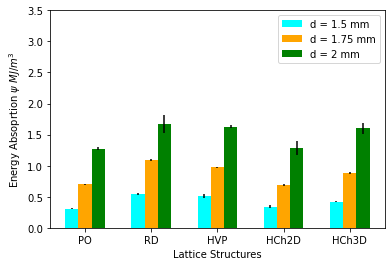

In [83]:
mean = pd.read_excel(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Mean.xlsx')
error = pd.read_excel(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Error.xlsx')
mean = mean.loc[:, 'Max_En_Abs']
error = error.loc[:, 'Max_En_Abs']
small = [i for i in mean[0:15:3]]
medium = [i for i in mean[1:15:3]]
large = [i for i in mean[2:15:3]] 
small_err = [i for i in error[0:15:3]]
medium_err = [i for i in error[1:15:3]]
large_err = [i for i in error[2:15:3]]
x = np.arange(5)
width = 0.2

plt.bar(x-0.2, small, width, color='cyan', label = 'd = 1.5 mm', yerr = small_err)
plt.bar(x, medium, width, color='orange', label = 'd = 1.75 mm', yerr = medium_err)
plt.bar(x+0.2, large, width, color='green', label = 'd = 2 mm', yerr = large_err)

plt.xticks(x, ['PO', 'RD', 'HVP', 'HCh2D', 'HCh3D'])
plt.xlabel("Lattice Structures")
plt.ylabel("Energy Absoprtion $ \psi$ $ MJ/m^3$")
plt.ylim([0, 3.5])
plt.legend()
plt.savefig(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\En_abs.pdf')

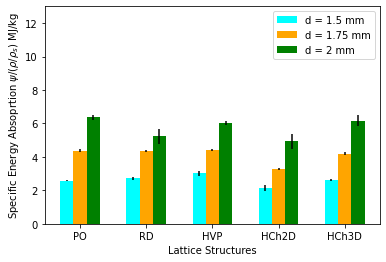

In [84]:
mean = pd.read_excel(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Mean.xlsx')
error = pd.read_excel(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Error.xlsx')
mean = mean.loc[:, 'Spec_Max_en_abs']
error = error.loc[:, 'Spec_Max_en_abs']
small = [i for i in mean[0:15:3]]
medium = [i for i in mean[1:15:3]]
large = [i for i in mean[2:15:3]] 
small_err = [i for i in error[0:15:3]]
medium_err = [i for i in error[1:15:3]]
large_err = [i for i in error[2:15:3]]
x = np.arange(5)
width = 0.2

plt.bar(x-0.2, small, width, color='cyan', label = 'd = 1.5 mm', yerr = small_err)
plt.bar(x, medium, width, color='orange', label = 'd = 1.75 mm', yerr = medium_err)
plt.bar(x+0.2, large, width, color='green', label = 'd = 2 mm', yerr = large_err)

plt.xticks(x, ['PO', 'RD', 'HVP', 'HCh2D', 'HCh3D'])
plt.xlabel("Lattice Structures")
plt.ylabel(r"Specific Energy Absoprtion $ \psi / (\rho / \rho_s) $ MJ/kg")
plt.ylim([0, 13])
plt.legend()
plt.savefig(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Spec_En_abs.pdf')

In [85]:
small_err

[0.0194625915103519,
 0.08874631500000008,
 0.1445835522558541,
 0.1768675122537466,
 0.04161423084173799]

### Absolute Properties

In [36]:
def compare(mean, error, diameter, y_limits, path):
    lattice = ["PO", "RD", "HVP", "HCh2D", "HCh3D"]
    lattice_axis = np.arange(len(lattice))

    fig1, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.15))

    ax1.set_ylabel("Yeild Stress $\sigma_y$ $MPa$", color = "red")
    ax2.set_ylabel("Plateau stress $\sigma_p$ $MPa$", color = "green")
    ax3.set_ylabel("Elastic Modulus $E$ $MPa$", color = "blue")

    if diameter == 1.5:
        rng = list(range(0, 14, 3))
    elif diameter == 1.75:
        rng = list(range(1, 14, 3))
    elif diameter == 2:
        rng = list(range(2, 15, 3))

    plt.xticks(lattice_axis, lattice)

    ax1.bar(lattice_axis - 0.2, mean.loc[rng, "Yield_Strengh"], 0.2, color = "red", label = "Yield stress $\sigma_y$ $MPa$", yerr = error.loc[rng, "Yield_Strengh"], alpha = 0.75)
    ax2.bar(lattice_axis, mean.loc[rng, "Plat_stress"], 0.2, color = "green", label = "Plateau stress $\sigma_p$ $MPa$", yerr = error.loc[rng, "Plat_stress"], alpha = 0.75)
    ax3.bar(lattice_axis + 0.2, mean.loc[rng, "Modulus"], 0.2, color = "blue", label = "Elastic modulus $E$ $MPa$", yerr = error.loc[rng, "Modulus"], alpha = 0.75)
    
    

    ax1.tick_params(axis = "y", colors = "red")
    ax2.tick_params(axis = "y", colors = "green")
    ax3.tick_params(axis = "y", colors = "blue")

    ax3.spines["left"].set_color("red")
    ax2.spines["right"].set_color("green")
    ax3.spines["right"].set_color("blue")

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()

    lines = lines_1 + lines_2 + lines_3
    labels = labels_1 + labels_2 + labels_3

    ax1.legend(lines, labels, prop={'size': 11})
    plt.rcParams['font.size'] = '10'


    ax1.set_ylim(0, y_limits[0])
    ax2.set_ylim(0, y_limits[1])
    ax3.set_ylim(0, y_limits[2])

    fig1.tight_layout()
    fig1.savefig(path + "\\" + str(diameter) + "_mm.pdf") 

In [37]:
mean_results = pd.read_excel(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Mean.xlsx')
std_results = pd.read_excel(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Error.xlsx')

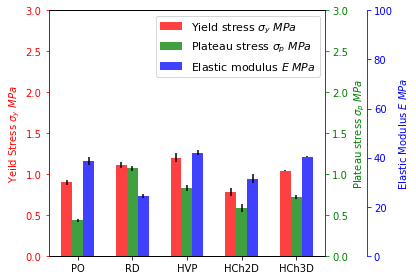

In [41]:
svpath = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Bar Charts"
compare(mean_results, std_results, diameter = 1.5, y_limits = [3, 3, 100], path = svpath)

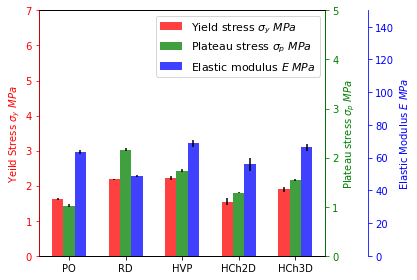

In [42]:
compare(mean_results, std_results, diameter = 1.75, y_limits = [7, 5, 150], path = svpath)

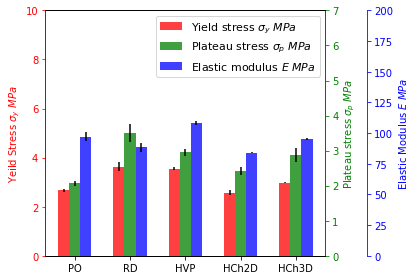

In [43]:
compare(mean_results, std_results, diameter = 2, y_limits = [10, 7, 200], path = svpath)

### Specific Properties

In [45]:
def compare_spec(mean, error, diameter, y_limits, path):
    lattice = ["PO", "RD", "HVP", "HCh2D", "HCh3D"]
    lattice_axis = np.arange(len(lattice))

    fig1, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))

    ax1.set_ylabel("Specific yield stress $\sigma_y/m$ $MPa/kg$", color = "red")
    ax2.set_ylabel("Specific plateau stress $\sigma_p/m$ $MPa/kg$", color = "green")
    ax3.set_ylabel("Specific elastic modulus $E$ $MPa/kg$", color = "blue")

    if diameter == 1.5:
        rng = list(range(0, 14, 3))
    elif diameter == 1.75:
        rng = list(range(1, 14, 3))
    elif diameter == 2:
        rng = list(range(2, 15, 3))

    plt.xticks(lattice_axis, lattice)

    ax1.bar(lattice_axis - 0.2, mean.loc[rng, "Spec_Yield_strengh"], 0.2, color = "red", label = "Specific Yield stress $\sigma_y/m$ $MPa$", yerr = error.loc[rng, "Spec_Yield_strengh"], alpha = 0.75)
    ax2.bar(lattice_axis, mean.loc[rng, "Spec_plat_stress"], 0.2, color = "green", label = "Specific plateau stress $\sigma_p/m$ $MPa$", yerr = error.loc[rng, "Spec_plat_stress"], alpha = 0.75)
    ax3.bar(lattice_axis + 0.2, mean.loc[rng, "Spec_Modulus"], 0.2, color = "blue", label = "Specific elastic modulus $E/m$ $MPa$", yerr= error.loc[rng, "Spec_Modulus"], alpha = 0.75)

    ax1.tick_params(axis = "y", colors = "red")
    ax2.tick_params(axis = "y", colors = "green")
    ax3.tick_params(axis = "y", colors = "blue")

    ax3.spines["left"].set_color("red")
    ax2.spines["right"].set_color("green")
    ax3.spines["right"].set_color("blue")

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()

    lines = lines_1 + lines_2 + lines_3
    labels = labels_1 + labels_2 + labels_3

    ax1.legend(lines, labels, prop={'size': 11})
    plt.rcParams['font.size'] = '10'

    ax1.set_ylim(0, y_limits[0])
    ax2.set_ylim(0, y_limits[1])
    ax3.set_ylim(0, y_limits[2])


    fig1.tight_layout()
    fig1.savefig(path + "\\" + str(diameter) + "_mm_spec.pdf")

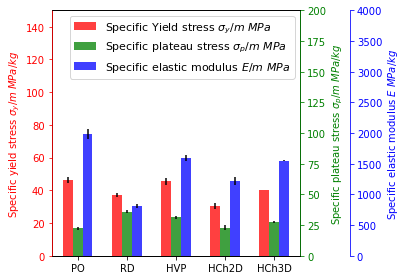

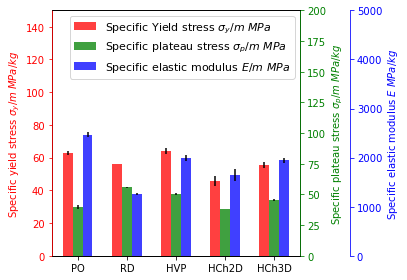

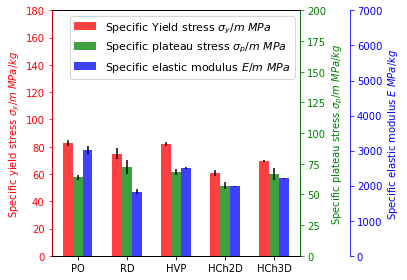

In [48]:
compare_spec(mean_results, std_results, 1.5, [150, 200, 4000], svpath)
compare_spec(mean_results, std_results, 1.75, [150, 200, 5000], svpath)
compare_spec(mean_results, std_results, 2, [180, 200, 7000], svpath)

## Regression

In [130]:
results = pd.read_excel(r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Mean.xlsx")
err = pd.read_excel(r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Error.xlsx")

In [131]:
results

,Unnamed: 0,Lattice Structure,Yield_Strengh,Spec_Yield_strengh,Modulus,Spec_Modulus,Max_En_Abs,Spec_Max_en_abs,Densification_Strain,Energy_Abs_Eff,Plat_stress,Spec_plat_stress,Yield_strain,Ultimate_Strengh,Spec_Ultimate_Strengh,Ultimate_Strain,Nominal Relative density
0,0,POL,0.896861,46.206139,38.542031,1985.679069,0.309813,2.581775,0.71779,34.703030,0.432743,22.294864,0.04485,0.896861,46.206139,0.04485,0.119948
1,1,POM,1.609681,62.633498,63.466062,2469.496565,0.699761,4.373507,0.69371,43.576740,1.023024,39.806374,0.05385,1.609681,62.633498,0.05385,0.157624
2,2,POH,2.665865,82.688132,97.108586,3012.052915,1.275301,6.376503,0.63391,47.924266,2.066308,64.091431,0.06307,2.666808,82.717383,0.34608,0.197857
3,3,RL,1.113760,37.399597,24.334580,817.145055,0.547283,2.736413,0.54629,41.425333,1.069068,35.898853,0.09786,1.324080,44.462055,0.54621,0.195260
4,4,RM,2.178020,56.120072,48.743850,1255.961096,1.087254,4.349015,0.53791,39.105508,2.161734,55.700444,0.09503,2.787820,71.832517,0.53788,0.254519
5,5,RH,3.633880,75.002679,88.315973,1822.827106,1.673230,5.228845,0.50861,37.594746,3.506418,72.371899,0.08397,4.464720,92.151084,0.50858,0.317736
6,6,HVPL,1.200660,45.479553,42.075729,1593.777596,0.511829,3.010760,0.63293,42.724986,0.827128,31.330596,0.05598,1.200660,45.479553,0.05598,0.168090
7,7,HVPM,2.218240,64.185181,68.827771,1991.544305,0.971845,4.417477,0.57908,43.913802,1.735687,50.222421,0.07173,2.219400,64.218761,0.32628,0.219190
8,8,HVPH,3.541904,81.704818,108.336731,2499.117214,1.627752,6.028712,0.57386,46.029671,2.952551,68.109590,0.07685,3.546154,81.802852,0.57382,0.273320
9,9,HCh2DL,0.782204,30.341497,31.480342,1221.114904,0.340499,2.128120,0.59856,41.470168,0.585081,22.695149,0.04397,0.823923,31.959778,0.59851,0.159364


In [132]:
strength_mean = np.array(results.loc[:, "Yield_Strengh"])/45.3
strength_err = np.array(err.loc[:, "Yield_Strengh"])/45.3

modulus_mean = np.array(results.loc[:, "Modulus"])/2797
modulus_err = np.array(err.loc[:, "Modulus"])/2797

energy_mean = np.array(results.loc[:, "Max_En_Abs"])
energy_err = np.array(err.loc[:, "Max_En_Abs"])

rel_dens = np.array(results.loc[:, "Nominal Relative density"])

In [133]:
strength_mean 

array([0.01979826, 0.03553379, 0.05884913, 0.02458631, 0.04807991,
       0.0802181 , 0.02650464, 0.04896777, 0.07818772, 0.01726719,
       0.03414176, 0.05681061, 0.02299102, 0.04178865, 0.06583208])

In [134]:
rel_dens

array([0.11994804, 0.15762429, 0.19785658, 0.19526048, 0.25451872,
       0.31773592, 0.16809002, 0.21918971, 0.27331992, 0.15936401,
       0.20730498, 0.25740873, 0.16083959, 0.20932466, 0.26005141])

In [236]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def func_powerlaw(x, m, c):
    return x**m * c

def get_reg_model(x, y, maxfev=5000):
    sol1, _ = curve_fit(lambda t,a,b: a*t**b,  x,  y,  p0=(4, 0.1))
    return sol1

def get_r2(sol, x):
    y_pred = sol[0] * (x**sol[1])
    return r2_score(y, y_pred)

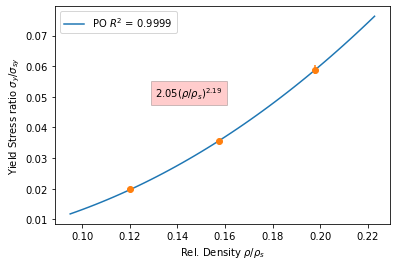

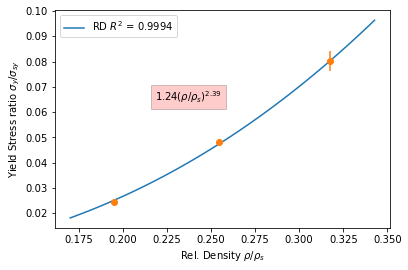

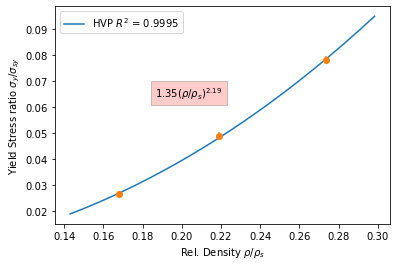

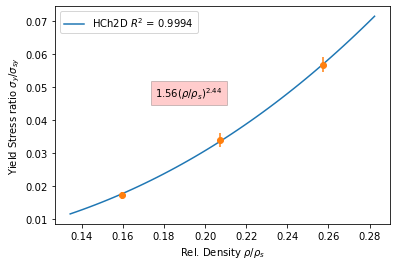

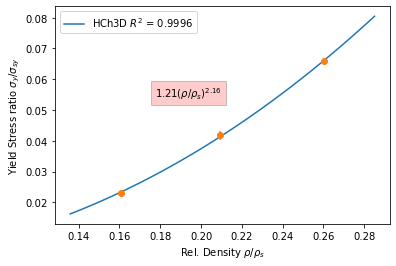

In [238]:
means = strength_mean
err = strength_err
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
path = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Regression"

figs = [fig1, fig2, fig3, fig4, fig5]
plots = [ax1, ax2, ax3, ax4, ax5]
name = "Yield Stress ratio $\sigma_y/\sigma_{sy}$"
lattice_names = ["PO", "RD", "HVP", "HCh2D", "HCh3D"]
sols = []
r2s = []

for i in range(5):
    plots[i].set_ylabel(name)
    plots[i].set_xlabel(r"Rel. Density $\rho/\rho_s$")
    y = means[3*i: 3*i+3]
    x = rel_dens[3*i: 3*i+3]
    error = err[3*i: 3*i+3]
    sol = get_reg_model(x, y)
    r2 = get_r2(sol, x)
    r2s.append(sol)
    sols.append(sol)
    
    x_new = np.linspace(x[0] - 0.025, x[2] + 0.025, 50)
    y_new = sol[0] * (x_new**sol[1])
    #y_new = func_powerlaw(x_new, *sol)
    power = '{:.2f}'.format(sol[1])
    
    eqn = "{:.2f}".format(sol[0]) + r"($\rho/\rho_s)^{%s}$" % (power)
    
    t = plots[i].text(0.4, 0.6, eqn, horizontalalignment='center', verticalalignment='center', transform=plots[i].transAxes)
    t.set_bbox(dict(facecolor='red', alpha=0.2))
    
    plots[i].plot(x_new, y_new, label = lattice_names[i] + " $R^2$ = " + '{0:.4f}'.format(r2))
    plots[i].errorbar(x, y, yerr = error, fmt = "o")
    plots[i].legend()
    figs[i].savefig(path + r"\\" + "Stren_" + lattice_names[i] + ".pdf")

In [239]:
sols

[array([2.04506024, 2.19063387]),
 array([1.23949978, 2.38540019]),
 array([1.34522664, 2.19139754]),
 array([1.55567367, 2.43681875]),
 array([1.2106095 , 2.15999334])]

In [225]:
result = {'n_1':[sols[i][0] for i in range(5)], 'C_1':[sols[i][1] for i in range(5)]}
result = pd.DataFrame(result)
result.to_excel(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Regression\strength.xlsx')

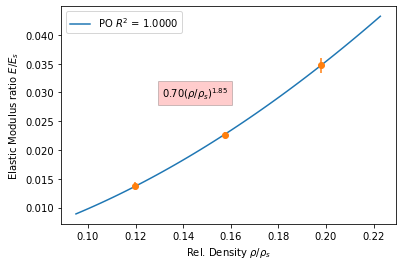

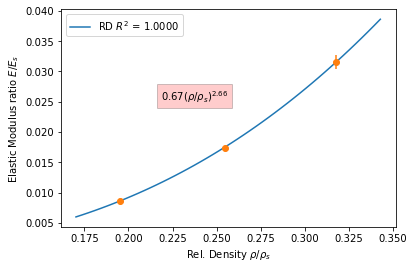

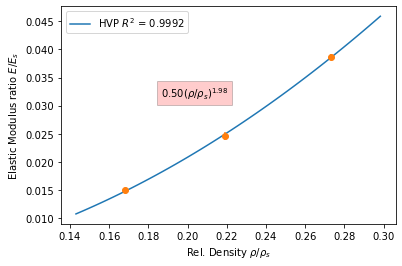

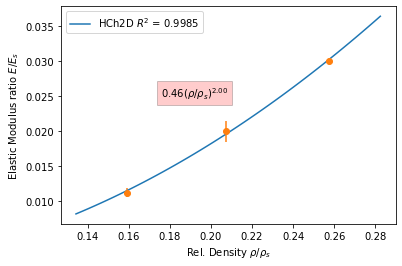

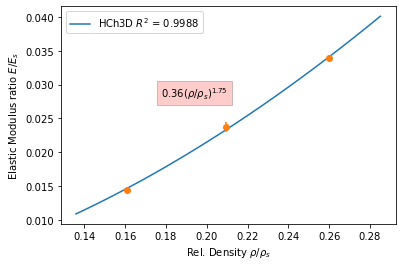

In [226]:
means = modulus_mean
err = modulus_err
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
path = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Regression"

figs = [fig1, fig2, fig3, fig4, fig5]
plots = [ax1, ax2, ax3, ax4, ax5]
name = "Elastic Modulus ratio $E/E_s$"
lattice_names = ["PO", "RD", "HVP", "HCh2D", "HCh3D"]
sols = []
r2s = []

for i in range(5):
    plots[i].set_ylabel(name)
    plots[i].set_xlabel(r"Rel. Density $\rho/\rho_s$")
    y = means[3*i: 3*i+3]
    x = rel_dens[3*i: 3*i+3]
    error = err[3*i: 3*i+3]
    sol = get_reg_model(x, y)
    r2 = get_r2(sol, x)
    r2s.append(sol)
    sols.append(sol)
    
    x_new = np.linspace(x[0] - 0.025, x[2] + 0.025, 50)
    y_new = func_powerlaw(x_new, *sol)
    power = '{:.2f}'.format(sol[0])
    
    eqn = "{:.2f}".format(sol[1]) + r"($\rho/\rho_s)^{%s}$" % (power)
    
    t = plots[i].text(0.4, 0.6, eqn, horizontalalignment='center', verticalalignment='center', transform=plots[i].transAxes)
    t.set_bbox(dict(facecolor='red', alpha=0.2))
    
    plots[i].plot(x_new, y_new, label = lattice_names[i] + " $R^2$ = " + '{0:.4f}'.format(r2))
    plots[i].errorbar(x, y, yerr = error, fmt = "o")
    plots[i].legend()
    figs[i].savefig(path + r"\\" + "Modulus_" + lattice_names[i] + ".pdf")

In [227]:
sols

[array([1.85304251, 0.69842743]),
 array([2.66004062, 0.66620578]),
 array([1.97621662, 0.501121  ]),
 array([2.00421838, 0.45870062]),
 array([1.75339532, 0.36196126])]

In [228]:
result = {'n_1':[sols[i][0] for i in range(5)], 'C_1':[sols[i][1] for i in range(5)]}
result = pd.DataFrame(result)
result.to_excel(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Regression\moduli.xlsx')

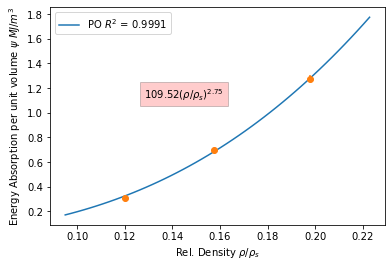

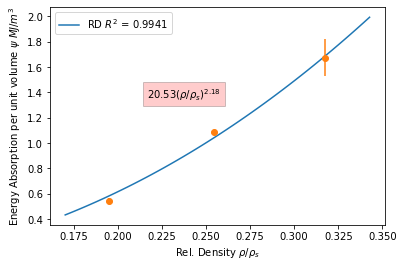

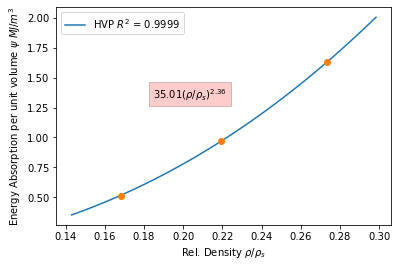

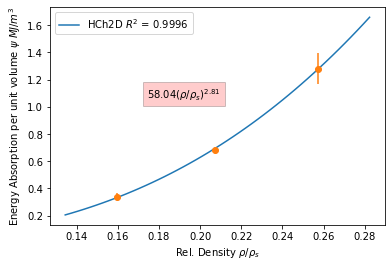

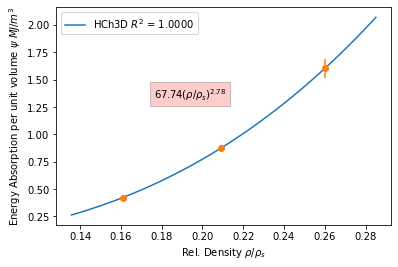

In [229]:
means = energy_mean
err = energy_err
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
path = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Regression"

figs = [fig1, fig2, fig3, fig4, fig5]
plots = [ax1, ax2, ax3, ax4, ax5]
name = "Energy Absorption per unit volume $\psi$ $MJ/m^3$"
lattice_names = ["PO", "RD", "HVP", "HCh2D", "HCh3D"]
sols = []
r2s = []

for i in range(5):
    plots[i].set_ylabel(name)
    plots[i].set_xlabel(r"Rel. Density $\rho/\rho_s$")
    y = means[3*i: 3*i+3]
    x = rel_dens[3*i: 3*i+3]
    error = err[3*i: 3*i+3]
    sol = get_reg_model(x, y)
    r2 = get_r2(sol, x)
    r2s.append(sol)
    sols.append(sol)
    
    x_new = np.linspace(x[0] - 0.025, x[2] + 0.025, 50)
    y_new = func_powerlaw(x_new, *sol)
    power = '{:.2f}'.format(sol[0])
    
    eqn = "{:.2f}".format(sol[1]) + r"($\rho/\rho_s)^{%s}$" % (power)
    
    t = plots[i].text(0.4, 0.6, eqn, horizontalalignment='center', verticalalignment='center', transform=plots[i].transAxes)
    t.set_bbox(dict(facecolor='red', alpha=0.2))
    
    plots[i].plot(x_new, y_new, label = lattice_names[i] + " $R^2$ = " + '{0:.4f}'.format(r2))
    plots[i].errorbar(x, y, yerr = error, fmt = "o")
    plots[i].legend()
    figs[i].savefig(path + r"\\" + "Energy_" + lattice_names[i] + ".pdf")

In [230]:
sols

[array([  2.74631635, 109.51901045]),
 array([ 2.17889133, 20.53423614]),
 array([ 2.36485245, 35.01154246]),
 array([ 2.8120499 , 58.04219153]),
 array([ 2.779623  , 67.74308921])]

In [231]:
result = {'n_1':[sols[i][0] for i in range(5)], 'C_1':[sols[i][1] for i in range(5)]}
result = pd.DataFrame(result)
result.to_excel(r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Regression\energy.xlsx')

In [ ]:
means = [strength_mean, modulus_mean, energy_mean]
err = [strength_err, modulus_err, energy_err]
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
path = r"C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\Regression"

figs = [fig1, fig2, fig3]
plots = [ax1, ax2, ax3]
names = ["Ultimate Strength", "Elastic Modulus", "Energy Absorption"]
lattice_names = ["PO", "R", "HVP", "HCh2D", "HCh3D"]
sols = [[], [], []]
r2s = [[], [], []]

for i in range(3):
    
    plots[i].set_ylabel(names[i])
    plots[i].set_xlabel("Rel. Density")
    
    for j in range(0, 14, 3):
        y = means[i][j:j+3]
        x = rel_dens[j:j+3]
        sol = get_reg_model(x, y)
        r2 = get_r2(sol, x)
        r2s[i].append(r2)
        sols[i].append(sol)
        
        x_new = np.linspace(x[0] - 0.025, x[2] + 0.025, 50)
        y_new = func_powerlaw(x_new, *sol)
        
        plots[i].plot(x_new, y_new, label = lattice_names[j//3] + " R^2 = " + '{0:.4f}'.format(r2))
        plots[i].scatter(x, y, marker = "x")
    
    plots[i].legend()
    figs[i].savefig(path + "\\" + names[i] + ".pdf")

In [108]:
pd.DataFrame(sols).to_excel(path + "\\" + "Results.xlsx")

In [109]:
sols

[[array([ 2.17415982, 87.93705559]),
  array([ 2.3124877 , 63.10943612]),
  array([ 2.3243798 , 74.48250446]),
  array([  2.82292546, 144.94820783]),
  array([  2.76166034, 156.47517707])],
 [array([1.83400456e+00, 1.85264110e+03]),
  array([   2.59810323, 1714.495947  ]),
  array([   2.09067013, 1665.36819878]),
  array([   1.99431398, 1239.06798932]),
  array([   1.74662185, 1002.09239788])],
 [array([  2.73590527, 104.36823259]),
  array([ 2.14079114, 19.46128666]),
  array([ 2.50687992, 43.34314341]),
  array([ 2.80668088, 55.94536955]),
  array([ 2.78045854, 67.76546632])]]

In [110]:
results = {"Lattice Structure" : lattice_names,
           "Strengh n": [], 
           "Strengh C": [],
           "Strengh R2": [],
          "Modulus n": [],
          "Modulus C": [],
          "Modulus R2": [],
          "Energy n": [],
          "Energy C": [], 
          "Energy R2": []}


for i in range(5):
    results["Strengh n"].append(sols[0][i][0])
    results["Strengh C"].append(sols[0][i][1])
    results["Strengh R2"].append(r2s[0][i])
    
    results["Modulus n"].append(sols[1][i][0])
    results["Modulus C"].append(sols[1][i][1])
    results["Modulus R2"].append(r2s[1][i])
    
    results["Energy n"].append(sols[2][i][0])
    results["Energy C"].append(sols[2][i][1])
    results["Energy R2"].append(r2s[1][i])

In [111]:
reg_res = pd.DataFrame(results)

In [112]:
reg_res

,Lattice Structure,Strengh n,Strengh C,Strengh R2,Modulus n,Modulus C,Modulus R2,Energy n,Energy C,Energy R2
0,PO,2.174160,87.937056,0.999216,1.834005,1852.641098,0.999337,2.735905,104.368233,0.999337
1,Rhom,2.312488,63.109436,0.980194,2.598103,1714.495947,0.996353,2.140791,19.461287,0.996353
2,HVP,2.324380,74.482504,0.999884,2.090670,1665.368199,0.998415,2.506880,43.343143,0.998415
3,HCh2D,2.822925,144.948208,0.999995,1.994314,1239.067989,0.999297,2.806681,55.945370,0.999297
4,HCh3D,2.761660,156.475177,0.998529,1.746622,1002.092398,0.999506,2.780459,67.765466,0.999506


In [113]:
reg_res.to_excel(r"C:\Users\Daniyar Syrlybayev\Desktop\Results_Regression.xlsx")

## FEM results PO

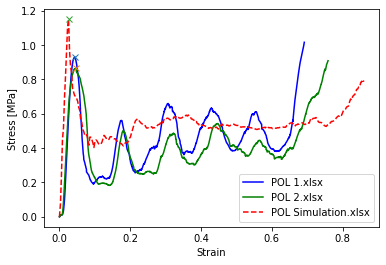

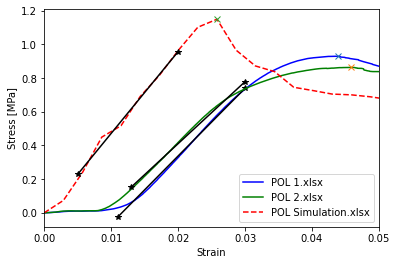

In [21]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\POL"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.011, 0.03), (0.013, 0.03), (0.005, 0.02)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (51.5, 51.5), rel_density = 0.12, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.6)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file)
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file)
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "POL")
fig2.savefig(output + "\\" + "POL_Elastic")

In [22]:
moduli

[40.23196091030052, 36.8521005379161, 48.60502519861094]

In [23]:
strenghs

[0.9300028277877274, 0.8637194834574419, 1.1499556979922707]

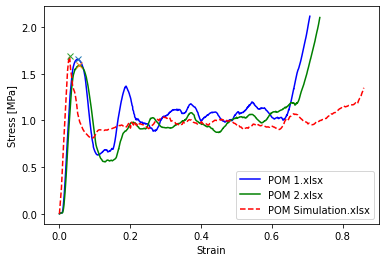

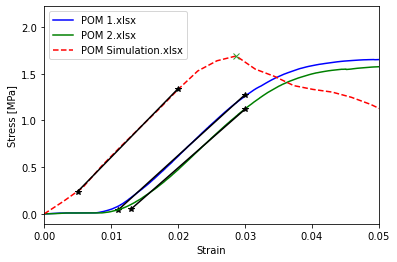

In [24]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\POM"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.011, 0.03), (0.013, 0.03), (0.005, 0.02)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (51.5, 51.5), rel_density = 0.16, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.6)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file)
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file)
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "POM")
fig2.savefig(output + "\\" + "POM_Elastic")

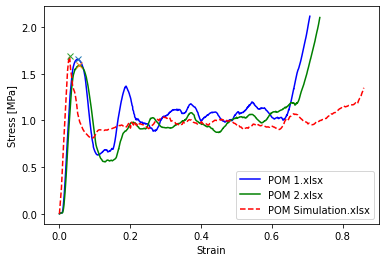

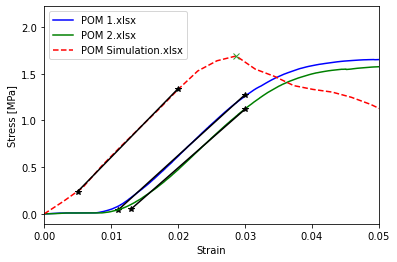

In [25]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\POM"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.011, 0.03), (0.013, 0.03), (0.005, 0.02)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (51.5, 51.5), rel_density = 0.12, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.6)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file)
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file)
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "POM")
fig2.savefig(output + "\\" + "POM_Elastic")

In [26]:
moduli

[65.11864294651497, 62.80127537158612, 73.4070934448988]

In [27]:
strenghs

[1.6541050051842776, 1.590310114054105, 1.690085776227731]

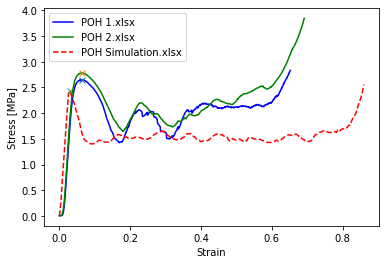

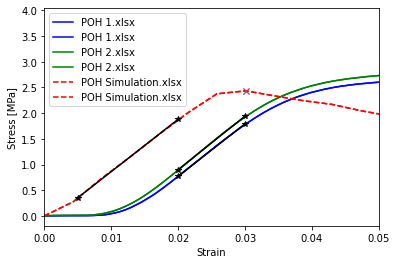

In [31]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\POH"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.02, 0.03), (0.02, 0.03), (0.005, 0.02)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (51.5, 51.5), rel_density = 0.2, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.6)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file)
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file)
    ax2.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file)
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "POH")
fig2.savefig(output + "\\" + "POH_Elastic")

In [32]:
moduli

[101.96647236403705, 104.47514560496525, 101.9352695322876]

In [33]:
strenghs

[2.650579696484117, 2.7851823923084176, 2.4340918088415493]

# Rhombic

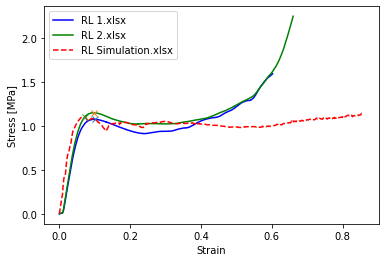

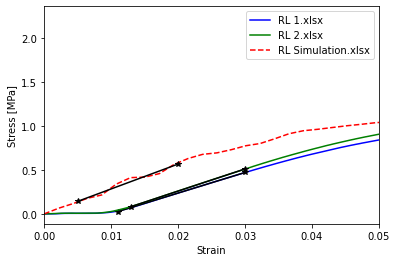

In [12]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\RL"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.011, 0.03), (0.013, 0.03), (0.005, 0.02)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (50, 50), rel_density = 0.2, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.2)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file)
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file)
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "RL")
fig2.savefig(output + "\\" + "RL_Elastic")

In [13]:
moduli

[23.439416040217495, 25.229743465095012, 28.310162762098496]

In [14]:
strenghs

[1.0769600000000001, 1.15056, 1.105464]

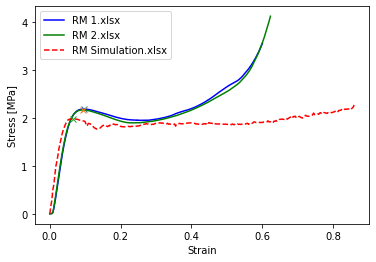

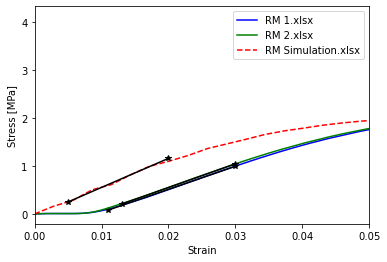

In [15]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\RM"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.011, 0.03), (0.013, 0.03), (0.005, 0.02)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (50, 50), rel_density = 0.25, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.2)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file)
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file)
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "RM")
fig2.savefig(output + "\\" + "RM_Elastic")

In [16]:
moduli

[48.0955187716404, 49.39218151838584, 60.580046249922646]

In [17]:
strenghs

[2.1866, 2.1694400000000003, 1.983768]

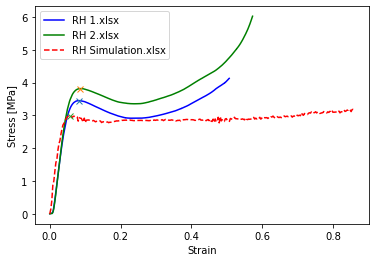

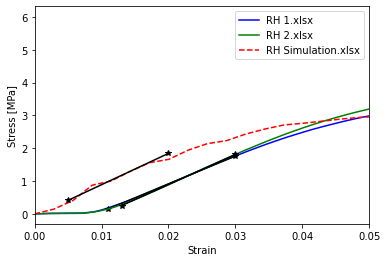

In [18]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\RH"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.011, 0.03), (0.013, 0.03), (0.005, 0.02)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (50, 50), rel_density = 0.25, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.2)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file)
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file)
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "RH")
fig2.savefig(output + "\\" + "RH_Elastic")

In [19]:
moduli

[84.94718378178845, 91.68476280904969, 95.4332640260349]

In [20]:
strenghs

[3.4504, 3.8173595999999996, 2.993292]

## HVPL

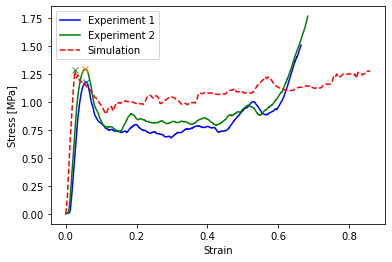

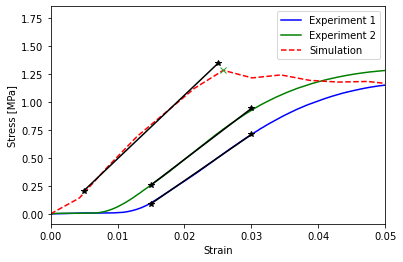

In [15]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\HVPL"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.015, 0.03), (0.015, 0.03), (0.005, 0.025)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (50, 50), rel_density = 0.17, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.2)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file[:-5])
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file[:-5])
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "HVPL.pdf")
fig2.savefig(output + "\\" + "HVPL_Elastic.pdf")

In [16]:
moduli

[41.26316782136532, 45.6109358201949, 56.826963365299754]

In [17]:
strenghs

[1.1808, 1.29256, 1.282844]

In [18]:
files

['Experiment 1.xlsx', 'Experiment 2.xlsx', 'Simulation.xlsx']

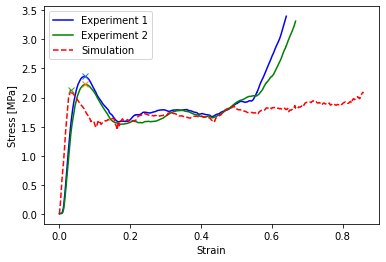

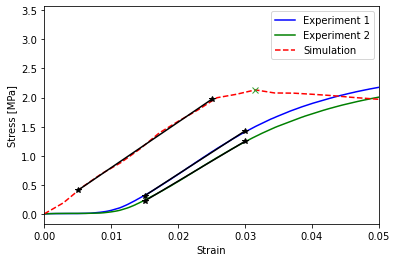

In [19]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\HVPM"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.015, 0.03), (0.015, 0.03), (0.005, 0.025)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (50, 50), rel_density = 0.17, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.2)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file[:-5])
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file[:-5])
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "HVPM.pdf")
fig2.savefig(output + "\\" + "HVPM_Elastic.pdf")

In [20]:
moduli

[74.3999905535467, 68.49667652788736, 78.21816803821027]

In [21]:
strenghs

[2.36288, 2.22444, 2.131096]

In [23]:
files 

['Experiment 1.xlsx', 'Experiment 2.xlsx', 'Simulation.xlsx']

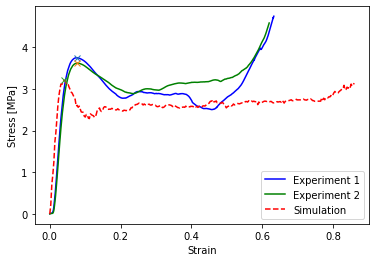

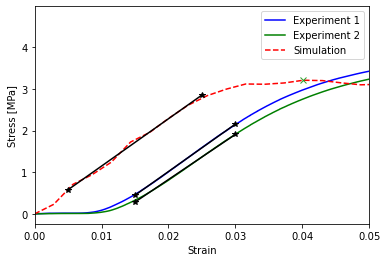

In [24]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\HVPH"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.015, 0.03), (0.015, 0.03), (0.005, 0.025)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (50, 50), rel_density = 0.17, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.2)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file[:-5])
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file[:-5])
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "HVPH.pdf")
fig2.savefig(output + "\\" + "HVPH_Elastic.pdf")

In [25]:
moduli

[113.93363712500631, 108.28683984123238, 113.6648247389764]

In [26]:
strenghs

[3.7480800000000003, 3.6190800000000003, 3.207484]

In [27]:
files

['Experiment 1.xlsx', 'Experiment 2.xlsx', 'Simulation.xlsx']

## HCh2D

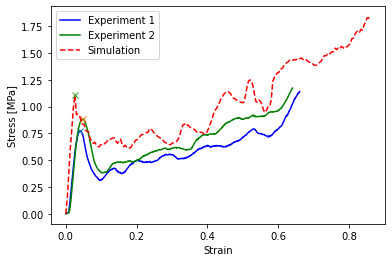

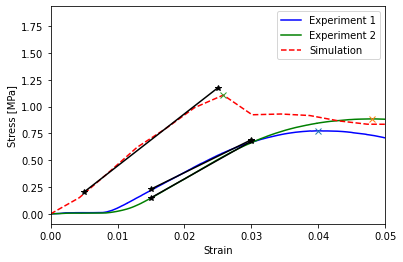

In [28]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\HCh2DL"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.015, 0.03), (0.015, 0.03), (0.005, 0.025)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (50, 50), rel_density = 0.17, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.2)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file[:-5])
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file[:-5])
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "HCh2DL.pdf")
fig2.savefig(output + "\\" + "HCh2DL_Elastic.pdf")

In [29]:
moduli

[30.68408356930734, 35.181359793563594, 48.59395626854083]

In [32]:
strenghs 

[0.7748, 0.8848799999999999, 1.10674]

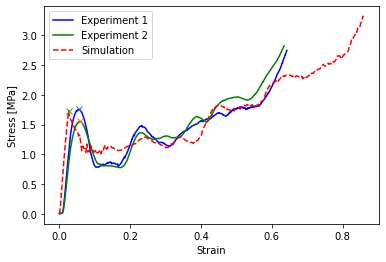

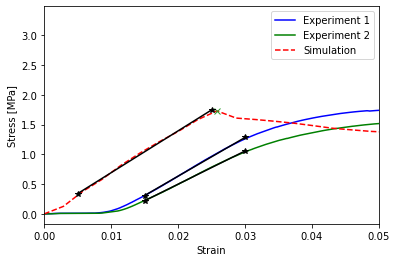

In [10]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\HCh2DM"
output = r"C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results\Results"

os.chdir(path)
files = os.listdir()

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
styles = ["-b", "-g", "--r"]
limits = [(0.015, 0.03), (0.015, 0.03), (0.005, 0.025)]
strenghs = []
moduli = []

for file in files:
    data = pd.read_excel(file)
    stress, strain = stress_strain(data, dimension = (50, 50), rel_density = 0.17, height = 50)
    strengh, displ = find_strengh(stress, strain, limit = 0.2)
    modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
    strenghs.append(strengh)
    moduli.append(modulus)
    
    stress1 = modulus * limits[files.index(file)][0] + f[1]
    stress2 = modulus * limits[files.index(file)][1] + f[1]
    
    ax1.plot(strain, stress, styles[files.index(file)], label = file[:-5])
    ax1.plot(displ, strengh, marker = "x")
    
    ax2.plot(strain, stress, styles[files.index(file)], label = file[:-5])
    ax2.plot(displ, strengh, marker = "x")
    ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
ax1.set_xlabel("Strain")
ax1.set_ylabel("Stress [MPa]")
ax1.legend()

ax2.set_xlabel("Strain")
ax2.set_ylabel("Stress [MPa]")
ax2.legend()
ax2.set_xlim(0, 0.05)

fig1.savefig(output + "\\" + "HCh2DM.pdf")
fig2.savefig(output + "\\" + "HCh2DM_Elastic.pdf")

In [11]:
moduli

[64.9852563748248, 55.70204578847798, 70.21576944518802]

In [12]:
strenghs

[1.75512, 1.5520399999999999, 1.7289919999999999]

In [13]:
files

['Experiment 1.xlsx', 'Experiment 2.xlsx', 'Simulation.xlsx']

## Conference Paper Correction

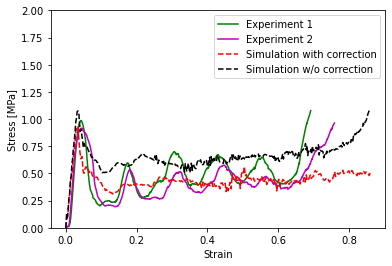

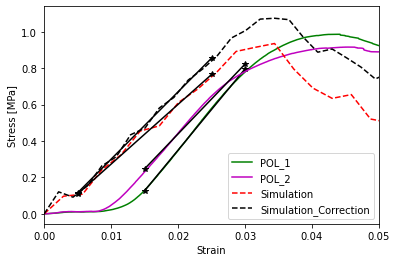

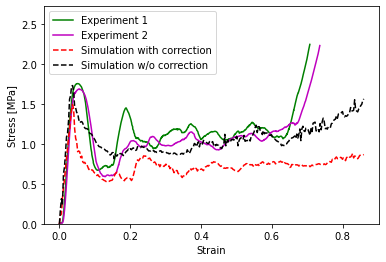

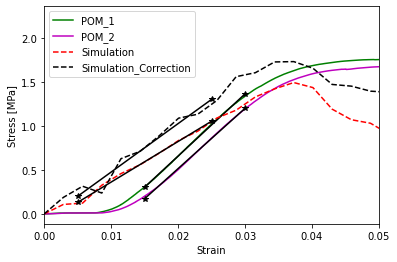

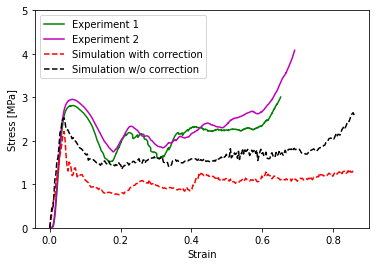

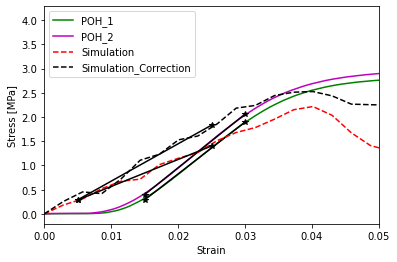

In [60]:
path = r"C:\Users\Daniyar Syrlybayev\Desktop\Paper\Results"
output_path = r"C:\Users\Daniyar Syrlybayev\Desktop\Paper\Results\Plots"

os.chdir(path)
folders = [r"\POL", r"\POM", r"\POH"]
strenghtss = []
modulis = []
limits = [(0.015, 0.03), (0.015, 0.03), (0.005, 0.025), (0.005, 0.025)]
styles = ["-g", "-m", "--r", "--k"]
lims = [2, 2.72, 5]
labels = ["Experiment 1", "Experiment 2", "Simulation with correction", "Simulation w/o correction"] 
names = ["POL.pdf", "POM.pdf", "POH.pdf"]

for folder in folders:
    os.chdir(path + folder)
    files = os.listdir()
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    moduli = []
    strengths = []
    
    for file in files:
        data = pd.read_excel(file)
        stress, strain = stress_strain(data, dimension = (50, 50), rel_density = 0.17, height = 50)
        strengh, displ = find_strengh(stress, strain, limit = 0.2)
        modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limits[files.index(file)][0], limit2 = limits[files.index(file)][1])
        strengths.append(strengh)
        moduli.append(modulus)

        stress1 = modulus * limits[files.index(file)][0] + f[1]
        stress2 = modulus * limits[files.index(file)][1] + f[1]

        ax1.plot(strain, stress, styles[files.index(file)], label = labels[files.index(file)])
        #ax1.plot(displ, strengh, marker = "x")

        ax2.plot(strain, stress, styles[files.index(file)], label = file[:-5])
        #ax2.plot(displ, strengh, marker = "x")
        ax2.plot([limits[files.index(file)][0], limits[files.index(file)][1]], [stress1, stress2], "-*k")
    
    modulis.append(moduli)
    strenghtss.append(strengths)
    ax1.set_xlabel("Strain")
    ax1.set_ylabel("Stress [MPa]")
    ax1.legend()

    ax2.set_xlabel("Strain")
    ax2.set_ylabel("Stress [MPa]")
    ax2.legend()
    ax2.set_xlim(0, 0.05)
    ax1.set_ylim(0, lims[folders.index(folder)])
    fig1.savefig(output_path + "\\" + names[folders.index(folder)])

In [33]:
modulis

[[44.640088861584346,
  38.365444283621166,
  32.82614080783973,
  36.99264503536702],
 [70.64780519424122, 68.44659455683535, 46.09830861391832, 55.01466043892733],
 [107.27137568481321,
  110.84884074281828,
  55.76411229176876,
  77.19028913164206]]

In [120]:
exp_mean = []
exp_std = []
for i in modulis:
    exp_mean.append(np.mean(np.array(i[:2])))
    exp_std.append(np.std(np.array(i[:2])))

In [35]:
exp_mean

[41.50276657260275, 69.54719987553828, 109.06010821381574]

In [36]:
exp_std

[3.13732228898159, 1.1006053187029323, 1.7887325290025373]

In [37]:
masses = np.array([19.41, 25.70, 32.24])/1000
spec_modulus_mean = []
spec_modulus_std = []

for i in range(3):
    spec_modulus_mean.append(exp_mean[i]/masses[i])
    spec_modulus_std.append(exp_std[i]/masses[i])
    

In [38]:
spec_modulus_mean

[2138.2156915302808, 2706.116726674641, 3382.7576989396935]

In [39]:
spec_modulus_std

[161.6343270984848, 42.825109677156895, 55.48177819486777]

In [40]:
with_corr = []
without_corr = []

for i in range(3):
    without_corr.append(modulis[i][2] / masses[i])
    with_corr.append(modulis[i][3] / masses[i])

In [41]:
without_corr

[1691.1973625883425, 1793.7085063781446, 1729.6560884543658]

In [42]:
with_corr

[1905.8549734861936, 2140.648266106122, 2394.2397373338104]

In [43]:
strenghtss

[[], [], []]

In [46]:
strenghtss

[[0.98664, 0.91632, 0.935684, 1.074484],
 [1.7548400000000002, 1.6871599999999998, 1.491248, 1.729064],
 [2.812, 2.9548, 2.217332, 2.5270639999999998]]

In [47]:
exp_mean = []
exp_std = []
for i in strenghtss:
    exp_mean.append(np.mean(np.array(i[:2])))
    exp_std.append(np.std(np.array(i[:2])))

In [48]:
exp_mean

[0.95148, 1.721, 2.8834]

In [49]:
exp_std

[0.03515999999999997, 0.0338400000000002, 0.07140000000000013]

In [50]:
masses = np.array([19.41, 25.70, 32.24])/1000
spec_stren_mean = []
spec_stren_std = []

for i in range(3):
    spec_stren_mean.append(exp_mean[i]/masses[i])
    spec_stren_std.append(exp_std[i]/masses[i])
    

In [51]:
spec_stren_mean

[49.020092735703244, 66.96498054474708, 89.43548387096773]

In [52]:
spec_stren_std

[1.8114374034003076, 1.3167315175097356, 2.21464019851117]

In [53]:
with_corr = []
without_corr = []

for i in range(3):
    without_corr.append(strenghtss[i][2] / masses[i])
    with_corr.append(strenghtss[i][3] / masses[i])

In [54]:
with_corr

[55.35723853683668, 67.27875486381322, 78.38287841191065]

In [55]:
without_corr

[48.206285419886655, 58.0252140077821, 68.7758064516129]

In [57]:
folder

'\\POH'

In [121]:
x = [0.12, 0.158, 0.198]
y = exp_mean

for i in exp_mean:
    y[y.index(i)] = i/2797

sol = get_reg_model(x, y, maxfev=5000)

In [122]:
sol

array([1.94749806, 0.91176199])

In [123]:
sol

array([1.94749806, 0.91176199])

In [124]:
exp_mean

[0.01483831482753048, 0.02486492666268798, 0.03899181559306963]

In [125]:
r2 = get_r2(sol, x)
r2

0.9997387125553827

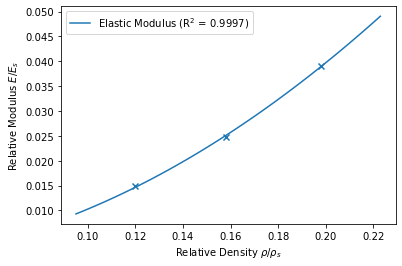

In [127]:
x_new = np.linspace(x[0] - 0.025, x[2] + 0.025, 50)
y_new = func_powerlaw(x_new, *sol)
fig1, ax1 = plt.subplots()       
ax1.plot(x_new, y_new, label = "Elastic Modulus (" + "R$^2$ = " + '{0:.4f})'.format(r2))
ax1.scatter(x, y, marker = "x")
plt.legend()
ax1.set_xlabel(r"Relative Density $\rho$/$\rho_s$")
ax1.set_ylabel(r"Relative Modulus $E/E_s$")
fig1.savefig(output_path + "\\" + "ERegression.pdf")

In [108]:
exp_mean = []
exp_std = []
for i in strenghtss:
    exp_mean.append(np.mean(np.array(i[:2])))
    exp_std.append(np.std(np.array(i[:2])))

In [109]:
x = [0.12, 0.158, 0.198]
y = exp_mean

for i in exp_mean:
    y[y.index(i)] = i/45.3

sol = get_reg_model(x, y, maxfev=5000)

In [110]:
sol

array([2.23821529, 2.38358928])

In [111]:
r2 = get_r2(sol, x)
r2

0.9997615070571487

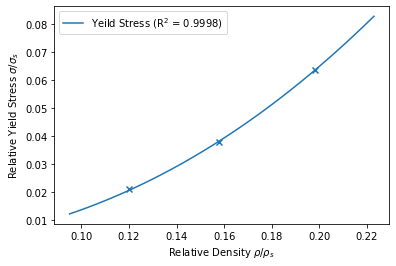

In [118]:
x_new = np.linspace(x[0] - 0.025, x[2] + 0.025, 50)
y_new = func_powerlaw(x_new, *sol)
fig1, ax1 = plt.subplots()       
ax1.plot(x_new, y_new, label = "Yeild Stress (" + "R$^2$ = " + '{0:.4f})'.format(r2))
ax1.scatter(x, y, marker = "x")
plt.legend()
ax1.set_xlabel(r"Relative Density $\rho$/$\rho_s$")
ax1.set_ylabel(r"Relative Yield Stress $\sigma/\sigma_s$")
fig1.savefig(output_path + "\\" + "SRegression.pdf")

In [119]:
sol

array([2.23821529, 2.38358928])

POL Completed
POL Completed
POL Completed
POM Completed
POM Completed
POM Completed
POH Completed
POH Completed
POH Completed
RL Completed
RL Completed
RL Completed
RM Completed
RM Completed
RM Completed
RH Completed
RH Completed
RH Completed
HVPL Completed
HVPL Completed
HVPL Completed
HVPM Completed
HVPM Completed
HVPM Completed
HVPH Completed
HVPH Completed
HVPH Completed
HCh2DL Completed
HCh2DL Completed
HCh2DL Completed
HCh2DM Completed
HCh2DM Completed
HCh2DM Completed
HCh2DH Completed
HCh2DH Completed
HCh2DH Completed
HCh3DL Completed
HCh3DL Completed
HCh3DL Completed
HCh3DM Completed
HCh3DM Completed
HCh3DM Completed
HCh3DH Completed
HCh3DH Completed
HCh3DH Completed


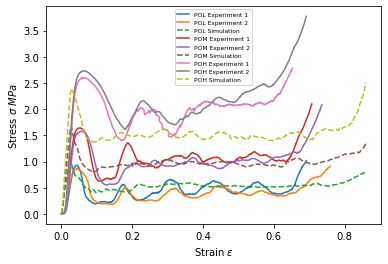

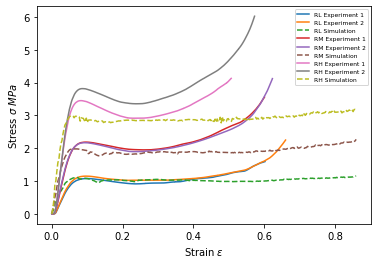

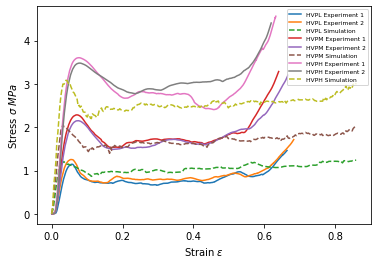

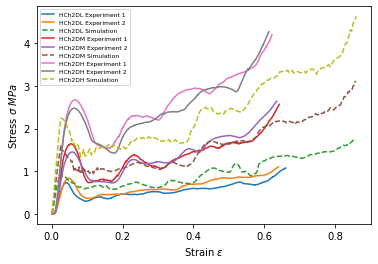

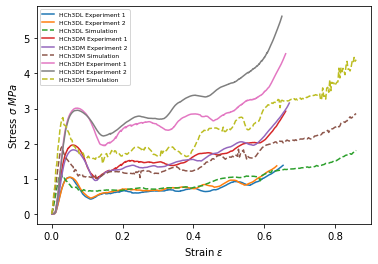

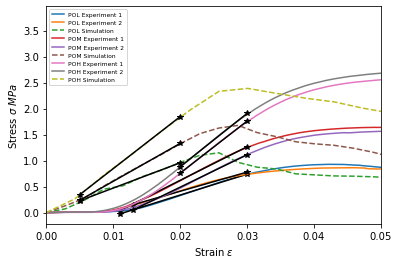

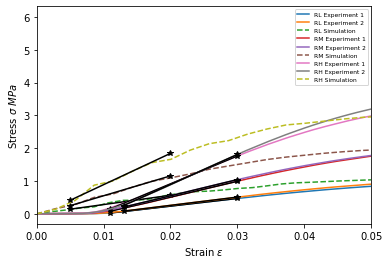

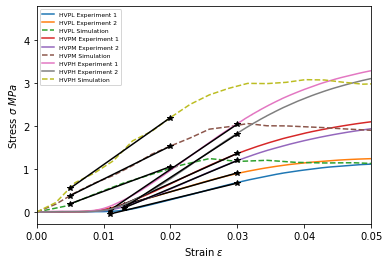

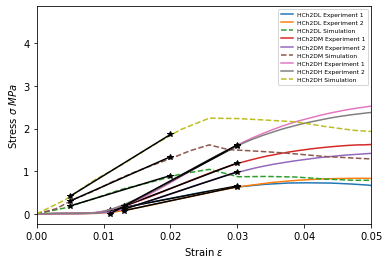

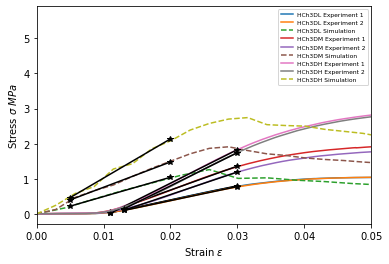

In [36]:
res_path = r'C:\Users\Daniyar Syrlybayev\Desktop\FEM_Results'
out_path = r'C:\Users\Daniyar Syrlybayev\Desktop\Lattice Compression\FEM_vs_Exp'

labels = ["d = 1.5 mm", "d = 1.75 mm", "d = 2 mm"]
masses = np.array([[19.41, 25.70, 32.24], [29.78, 38.81, 48.45], [26.40, 34.56, 43.35], [25.78, 33.80, 42.46], [26.02, 34.12, 42.89]]) * 10**-3
dimensions = [[(51.5, 51.5), (51.7, 51.7), (52, 52)], [(50, 50), (50, 50), (50, 50)], [(51.5, 50), (51.7, 50), (52, 50)], [(51.5, 51.5), (51.7, 51.7), (52, 52)], [(51.5, 51.5), (51.7, 51.7), (52, 52)]]
rel_dens = np.array([[0.12, 0.16, 0.20], [0.20, 0.25, 0.32], [0.17, 0.22, 0.27], [0.16, 0.21, 0.26], [0.16, 0.21, 0.26]])

limits_fem = [0.005, 0.02]
limits_1 = [[(0.011, 0.03), (0.011, 0.03), (0.02, 0.03)], 
            [(0.011, 0.03), (0.011, 0.03), (0.011, 0.03)], 
            [(0.011, 0.03), (0.011, 0.03), (0.011, 0.03)], 
            [(0.011, 0.03), (0.011, 0.03), (0.011, 0.03)], 
            [(0.011, 0.03), (0.011, 0.03), (0.011, 0.03)]]

limits_2 = [[(0.013, 0.03), (0.013, 0.03), (0.02, 0.03)], 
            [(0.013, 0.03), (0.013, 0.03), (0.013, 0.03)], 
            [(0.013, 0.03), (0.013, 0.03), (0.013, 0.03)], 
            [(0.013, 0.03), (0.013, 0.03), (0.013, 0.03)], 
            [(0.013, 0.03), (0.013, 0.03), (0.013, 0.03)]]


results_fem = {'Data': [], 
           'Y_stress': [],
          'P_stress': [],
            'Modulus': []}

folders = [['POL', 'POM', 'POH'], ['RL', 'RM', 'RH'], 
         ['HVPL', 'HVPM', 'HVPH'], ['HCh2DL', 'HCh2DM', 'HCh2DH'], 
         ['HCh3DL', 'HCh3DM', 'HCh3DH']]

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()

fig6, ax6 = plt.subplots()
fig7, ax7 = plt.subplots()
fig8, ax8 = plt.subplots()
fig9, ax9 = plt.subplots()
fig10, ax10 = plt.subplots()

plots = [ax1, ax2, ax3, ax4, ax5]
figs = [fig1, fig2, fig3, fig4, fig5]

plots_el = [ax6, ax7, ax8, ax9, ax10]
figs_el = [fig6, fig7, fig8, fig9, fig10]

for i in range(5):
    for j in range(3):
        os.chdir(res_path + '\\' + folders[i][j])
        files = os.listdir()
        for file in files:
            
            
            if file == 'Experiment 1.xlsx':
                limit = limits_1[i][j]
                style = '-'
            elif file == 'Experiment 2.xlsx':
                limit = limits_2[i][j]
                style = '-'
            elif file == 'Simulation.xlsx':
                limit = limits_fem
                style = '--'
            
            data = pd.read_excel(file)
            stress, strain = stress_strain(data, dimension = dimensions[i][j], rel_density = rel_dens[i][j], height = 50)
            strengh, displ = find_strengh(stress, strain, limit = 0.6)
            modulus, f, _ = find_elastic_modulus(stress, strain, limit1 = limit[0], limit2 = limit[1])

            stress1 = modulus * limit[0] + f[1]
            stress2 = modulus * limit[1] + f[1]

            plots[i].plot(strain, stress, style, label = folders[i][j] + " " + file[:-5])
            #plots[i].plot(displ, strengh, marker = "x")

            plots_el[i].plot(strain, stress, style, label = folders[i][j] + " " + file[:-5])
            #plots_el[i].plot(displ, strengh, marker = "x")
            plots_el[i].plot([limit[0], limit[1]], [stress1, stress2], "-*k")
            
            if file == 'Simulation.xlsx':
                results_fem['Data'].append(folders[i][j])
                results_fem['Modulus'].append(modulus)
                y_index = np.where(strain == displ)[0][0]
                d_index = np.argmin(abs(strain - 0.78))
                plat = np.trapz(stress[y_index: d_index], strain[y_index: d_index])/(0.78 - displ)
                results_fem['P_stress'].append(plat)
                results_fem['Y_stress'].append(strengh)
            
            print(folders[i][j] + " Completed")
            limit = None
            style = None  
        
    plots[i].set_xlabel("Strain $\epsilon$")
    plots[i].set_ylabel("Stress $\sigma$ $MPa$")
    plots[i].legend(prop={'size': 6})

    plots_el[i].set_xlabel("Strain $\epsilon$")
    plots_el[i].set_ylabel("Stress $\sigma$ $MPa$")
    plots_el[i].legend(prop={'size': 6})
    plots_el[i].set_xlim(0, 0.05)

    figs[i].savefig(out_path + "\\" + folders[i][j] + '.pdf')
    figs_el[i].savefig(out_path + "\\" + folders[i][j] + 'el.pdf')




In [16]:
file

'Experiment 1.xlsx'

In [38]:
results_fem = pd.DataFrame(results_fem)

In [39]:
results_fem 

,Data,Y_stress,P_stress,Modulus
0,POL,1.149956,0.529811,48.605025
1,POM,1.677035,0.963607,72.840245
2,POH,2.387507,1.501728,99.984400
3,RL,1.105464,1.025334,28.310163
4,RM,1.983768,1.896404,60.580046
5,RH,2.993292,2.883713,95.433264
6,HVPL,1.245480,1.037939,57.850123
7,HVPM,2.061021,1.676966,77.076366
8,HVPH,3.084119,2.516850,109.892862
9,HCh2DL,1.238428,1.308592,47.531388


In [40]:
results_fem.to_excel(out_path + "\\" + 'FEM_Sum.xlsx')